# Preperation

In [ ]:
import torch
import matplotlib.pyplot as plt
import os
import time
from google.colab import drive

from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize, transforms, Resize, Grayscale

def get_mnist(resize=False, batch_size=100):
    if resize:
        transform = transforms.Compose(
            [
                ToTensor(),
                Resize((32, 32)),
                Normalize((0.5,), (0.5, )),
            ]
        )
    else:
        transform = transforms.Compose(
            [
                ToTensor(),
                Normalize((0.5,), (0.5, )),
            ]
        ) 
    MNIST_train = datasets.MNIST(
        root=".",
        train=True,
        download=True,
        transform=transform
    )
    MNIST_test = datasets.MNIST(
        root=".",
        train=False,
        download=True,
        transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        MNIST_train, 
        batch_size=batch_size, 
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        MNIST_test, 
        batch_size=batch_size,
        shuffle=True
    )
    return (train_loader, test_loader)

def get_cifar10():
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    trainset = datasets.CIFAR10(
        root='.', 
        train=True,
        download=True, 
        transform=transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, 
        batch_size=100,
        shuffle=True, 
        num_workers=2
    )
    testset = datasets.CIFAR10(
        root='.', 
        train=False,
        download=True, 
        transform=transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, 
        batch_size=100,
        shuffle=False, 
        num_workers=2
    )
    return (trainloader, testloader)

def get_cifar100():
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    trainset = datasets.CIFAR100(
        root='.', 
        train=True,
        download=True, 
        transform=transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, 
        batch_size=100,
        shuffle=True, 
        num_workers=2
    )
    testset = datasets.CIFAR100(
        root='.', 
        train=False,
        download=True, 
        transform=transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, 
        batch_size=100,
        shuffle=False, 
        num_workers=2
    )
    return (trainloader, testloader)

def fit(
    model, 
    name, 
    train_loader,
    test_loader,
    epoches, 
    learning_rate,
    log_interval, 
    loss_function,
    deep_mode = False
):
    train_loss = []
    train_counter = []
    train_accuracy = []
    test_loss = []
    test_counter = [i * len(train_loader.dataset) for i in range(1, epoches+1)]
    test_accuracy = []
    # log = []

    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    # save_dir = "~/results/{}".format(name)

    # if not os.path.exists(save_dir):
    #     os.mkdir(save_dir)

    start_time = time.time()
    # file = open("~/results/{}/{}.txt".format(name, name), 'w')

    for epoch in range(1, epoches+1):
        model.train()
        for batch_index, (x, y) in enumerate(train_loader):
            x = x.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()
            if batch_index % log_interval == 0:
                correct = 0
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(y.data.view_as(pred)).sum()
                train_loss.append(loss.item())
                train_accuracy.append(correct)
                train_counter.append(
                    (batch_index*100)+((epoch-1) * len(train_loader.dataset))
                )
                # torch.save(model, save_dir+"/{}.pkl".format(name))
                print(
                "Train Epoch: {}/{} [{}/{} ({:.0f}%)] Loss: {:.4f} Accuracy: {:.4f}".format(
                    epoch, 
                    epoches,
                    batch_index*len(x), 
                    len(train_loader.dataset),
                    100*batch_index/len(train_loader), 
                    loss.item(),
                    correct
                    )
                )
                # file.write(
                #     "Train Epoch: {}/{} [{}/{} ({:.0f}%)] Loss: {:.4f} Accuracy: {:.4f}".format(
                #     epoch, 
                #     epoches,
                #     batch_index*len(x), 
                #     len(train_loader.dataset),
                #     100*batch_index/len(train_loader), 
                #     loss.item(),
                #     correct
                #     ) 
                # )
                # file.write("\n")

        model.eval()
        t_loss = 0
        correct = 0 
        with torch.no_grad():
            for (x, y) in test_loader:
                x = x.cuda()
                y = y.cuda()
                output = model(x)
                t_loss = loss_function(output, y)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(y.data.view_as(pred)).sum()
        test_loss.append(t_loss)
        test_accuracy.append(100*correct/len(test_loader.dataset))
        print(
            "\nTest Set: Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
                t_loss,
                correct, 
                len(test_loader.dataset),
                100*correct/len(test_loader.dataset)
            )
        )
        # log.append(           
        #     "\nTest Set: Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        #         t_loss,
        #         correct, 
        #         len(test_loader.dataset),
        #         100*correct/len(test_loader.dataset)
        #     ))
        if deep_mode:
            if epoch % 5 == 0:
                test_counter = [i * len(train_loader.dataset) for i in range(1, epoch+1)]
                plt.plot(train_counter, train_loss)
                plt.plot(test_counter, test_loss, color="coral")
                plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
                plt.xlabel("Number of training examples")
                plt.ylabel("Negative log-likelihood loss")
                # plt.savefig("./results/{}/{}_Loss_Ep{}.png".format(name, name, epoch))
                plt.show()
                plt.clf()
                plt.plot(train_counter, train_accuracy)
                plt.plot(test_counter, test_accuracy, color="coral")
                plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper right')
                plt.xlabel("Number of training examples")
                plt.ylabel("Accuracy")
                # plt.savefig("./results/{}/{}_Accuracy_Ep{}.png".format(name, name, epoch))
                plt.show()
                plt.clf()
                plt.close()
            else:
                pass
        else:
            test_counter = [i * len(train_loader.dataset) for i in range(1, epoch+1)]
            plt.plot(train_counter, train_loss)
            plt.plot(test_counter, test_loss, color="coral")
            plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
            plt.xlabel("Number of training examples")
            plt.ylabel("Negative log-likelihood loss")
            # plt.savefig("./results/{}/{}_Loss_Ep{}.png".format(name, name, epoch))
            plt.show()
            plt.clf()
            plt.plot(train_counter, train_accuracy)
            plt.plot(test_counter, test_accuracy, color="coral")
            plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper right')
            plt.xlabel("Number of training examples")
            plt.ylabel("Accuracy")
            # plt.savefig("./results/{}/{}_Accuracy_Ep{}.png".format(name, name, epoch))
            plt.show()
            plt.clf()
            plt.close()
    # for l in log:
    #     file.write(l)
    #     file.write("\n")
    end_time = time.time()
    total_time = end_time - start_time
    # file.write("Total time using: {:.2f} sec.".format(total_time))
    # file.write("\n")
    # file.close()
    print("Total Time Takes {}.".format(total_time))

    

# Model


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class ResNet(ResNet):
    def __init__(self, config, in_channels, num_classes):
        if config == "resnet18":
            super(ResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes) # Based on ResNet18
        if config == "resnet34":
            super(ResNet, self).__init__(BasicBlock, [3, 4, 6, 3], num_classes) # Based on ResNet34
        if config == "resnet50":
            super(ResNet, self).__init__(Bottleneck, [3, 4, 6, 3], num_classes) # Based on ResNet50
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=1, padding=3,bias=False)

#定义VGG各种不同的结构和最后的全连接层结构
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256,'M', 512, 'M', 512,'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'FC':    [512*1*1, 4096, 100]
}

#将数据展开成二维数据，用在全连接层之前和卷积层之后
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

class VGG(nn.Module):
    # nn.Module是一个特殊的nn模块，加载nn.Module，这是为了继承父类
    def __init__(self, config):
        super(VGG, self).__init__()
        # super 加载父类中的__init__()函数
        self.VGG_layer = self.vgg_block(cfg[config])
        self.FC_layer = self.fc_block(cfg['FC'])
    #前向传播算法
    def forward(self, x):
        out_vgg = self.VGG_layer(x)
        out = out_vgg.view(out_vgg.size(0), -1)
        # 这一步将out拉成out.size(0)的一维向量
        out = self.FC_layer(out_vgg)
        return out
    #VGG模块
    def vgg_block(self, cfg_vgg):
        layers = []
        in_channels = 3
        for out_channels in cfg_vgg:
            if out_channels == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1, bias=False))
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU(inplace=True))
                in_channels = out_channels
        return nn.Sequential(*layers)
    #全连接模块
    def fc_block(self, cfg_fc):
        fc_net = nn.Sequential()
        fc_features, fc_hidden_units, fc_output_units = cfg_fc[0:]
        fc_net.add_module("fc", nn.Sequential(
            FlattenLayer(),
            nn.Linear(fc_features, fc_hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(fc_hidden_units, fc_hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(fc_hidden_units, fc_output_units)
        ))
        return fc_net

#Main

In [ ]:
import torch
from torch.nn import CrossEntropyLoss

# train_mnist, test_mnist = get_mnist(resize=False)
train_cifar10, test_cifar10 = get_cifar10()
train_cifar100, test_cifar100 = get_cifar100()


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified



Extracting ./cifar-100-python.tar.gz to .
Files already downloaded and verified


# VGG11


Train Epoch: 1/5 [0/60000 (0%)] Loss: 2.3202 Accuracy: 10.0000
Train Epoch: 1/5 [1000/60000 (2%)] Loss: 2.2266 Accuracy: 16.0000
Train Epoch: 1/5 [2000/60000 (3%)] Loss: 1.8647 Accuracy: 26.0000
Train Epoch: 1/5 [3000/60000 (5%)] Loss: 1.4860 Accuracy: 48.0000
Train Epoch: 1/5 [4000/60000 (7%)] Loss: 1.2260 Accuracy: 49.0000
Train Epoch: 1/5 [5000/60000 (8%)] Loss: 1.1452 Accuracy: 52.0000
Train Epoch: 1/5 [6000/60000 (10%)] Loss: 0.8106 Accuracy: 71.0000
Train Epoch: 1/5 [7000/60000 (12%)] Loss: 0.3945 Accuracy: 88.0000
Train Epoch: 1/5 [8000/60000 (13%)] Loss: 0.4781 Accuracy: 85.0000
Train Epoch: 1/5 [9000/60000 (15%)] Loss: 0.3129 Accuracy: 89.0000
Train Epoch: 1/5 [10000/60000 (17%)] Loss: 0.3544 Accuracy: 89.0000
Train Epoch: 1/5 [11000/60000 (18%)] Loss: 0.1682 Accuracy: 95.0000
Train Epoch: 1/5 [12000/60000 (20%)] Loss: 0.2353 Accuracy: 94.0000
Train Epoch: 1/5 [13000/60000 (22%)] Loss: 0.2228 Accuracy: 93.0000
Train Epoch: 1/5 [14000/60000 (23%)] Loss: 0.1220 Accuracy: 95.0000

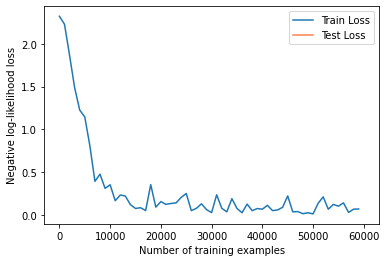

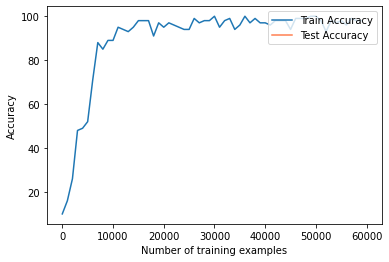

Train Epoch: 2/5 [0/60000 (0%)] Loss: 0.0141 Accuracy: 100.0000
Train Epoch: 2/5 [1000/60000 (2%)] Loss: 0.0083 Accuracy: 100.0000
Train Epoch: 2/5 [2000/60000 (3%)] Loss: 0.0456 Accuracy: 99.0000
Train Epoch: 2/5 [3000/60000 (5%)] Loss: 0.0106 Accuracy: 100.0000
Train Epoch: 2/5 [4000/60000 (7%)] Loss: 0.1702 Accuracy: 96.0000
Train Epoch: 2/5 [5000/60000 (8%)] Loss: 0.0105 Accuracy: 100.0000
Train Epoch: 2/5 [6000/60000 (10%)] Loss: 0.1245 Accuracy: 96.0000
Train Epoch: 2/5 [7000/60000 (12%)] Loss: 0.0559 Accuracy: 97.0000
Train Epoch: 2/5 [8000/60000 (13%)] Loss: 0.0321 Accuracy: 99.0000
Train Epoch: 2/5 [9000/60000 (15%)] Loss: 0.1709 Accuracy: 95.0000
Train Epoch: 2/5 [10000/60000 (17%)] Loss: 0.0357 Accuracy: 99.0000
Train Epoch: 2/5 [11000/60000 (18%)] Loss: 0.0397 Accuracy: 98.0000
Train Epoch: 2/5 [12000/60000 (20%)] Loss: 0.0108 Accuracy: 100.0000
Train Epoch: 2/5 [13000/60000 (22%)] Loss: 0.1527 Accuracy: 98.0000
Train Epoch: 2/5 [14000/60000 (23%)] Loss: 0.0201 Accuracy: 99

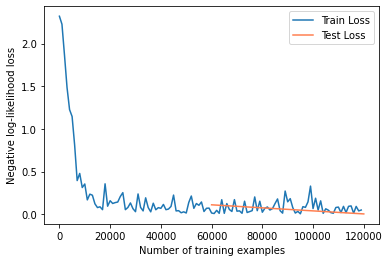

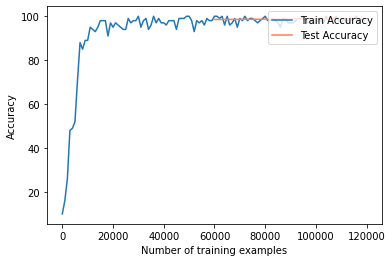

Train Epoch: 3/5 [0/60000 (0%)] Loss: 0.0103 Accuracy: 100.0000
Train Epoch: 3/5 [1000/60000 (2%)] Loss: 0.0100 Accuracy: 100.0000
Train Epoch: 3/5 [2000/60000 (3%)] Loss: 0.0076 Accuracy: 100.0000
Train Epoch: 3/5 [3000/60000 (5%)] Loss: 0.0054 Accuracy: 100.0000
Train Epoch: 3/5 [4000/60000 (7%)] Loss: 0.0359 Accuracy: 99.0000
Train Epoch: 3/5 [5000/60000 (8%)] Loss: 0.0977 Accuracy: 98.0000
Train Epoch: 3/5 [6000/60000 (10%)] Loss: 0.0129 Accuracy: 100.0000
Train Epoch: 3/5 [7000/60000 (12%)] Loss: 0.0604 Accuracy: 99.0000
Train Epoch: 3/5 [8000/60000 (13%)] Loss: 0.0178 Accuracy: 100.0000
Train Epoch: 3/5 [9000/60000 (15%)] Loss: 0.0343 Accuracy: 99.0000
Train Epoch: 3/5 [10000/60000 (17%)] Loss: 0.0100 Accuracy: 100.0000
Train Epoch: 3/5 [11000/60000 (18%)] Loss: 0.0303 Accuracy: 99.0000
Train Epoch: 3/5 [12000/60000 (20%)] Loss: 0.0609 Accuracy: 99.0000
Train Epoch: 3/5 [13000/60000 (22%)] Loss: 0.0623 Accuracy: 99.0000
Train Epoch: 3/5 [14000/60000 (23%)] Loss: 0.1449 Accuracy: 

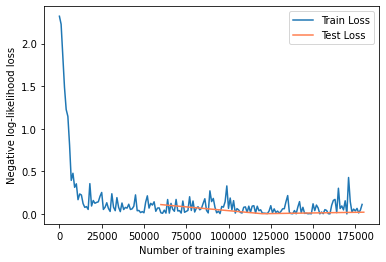

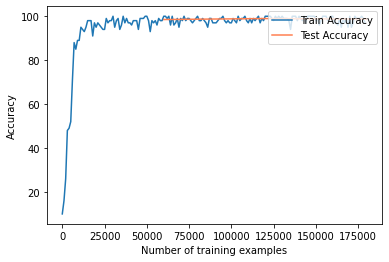

Train Epoch: 4/5 [0/60000 (0%)] Loss: 0.0254 Accuracy: 99.0000
Train Epoch: 4/5 [1000/60000 (2%)] Loss: 0.0321 Accuracy: 99.0000
Train Epoch: 4/5 [2000/60000 (3%)] Loss: 0.1372 Accuracy: 99.0000
Train Epoch: 4/5 [3000/60000 (5%)] Loss: 0.0029 Accuracy: 100.0000
Train Epoch: 4/5 [4000/60000 (7%)] Loss: 0.0082 Accuracy: 100.0000
Train Epoch: 4/5 [5000/60000 (8%)] Loss: 0.0423 Accuracy: 98.0000
Train Epoch: 4/5 [6000/60000 (10%)] Loss: 0.0721 Accuracy: 98.0000
Train Epoch: 4/5 [7000/60000 (12%)] Loss: 0.0383 Accuracy: 99.0000
Train Epoch: 4/5 [8000/60000 (13%)] Loss: 0.0927 Accuracy: 98.0000
Train Epoch: 4/5 [9000/60000 (15%)] Loss: 0.0073 Accuracy: 100.0000
Train Epoch: 4/5 [10000/60000 (17%)] Loss: 0.0064 Accuracy: 100.0000
Train Epoch: 4/5 [11000/60000 (18%)] Loss: 0.0320 Accuracy: 99.0000
Train Epoch: 4/5 [12000/60000 (20%)] Loss: 0.0422 Accuracy: 99.0000
Train Epoch: 4/5 [13000/60000 (22%)] Loss: 0.0012 Accuracy: 100.0000
Train Epoch: 4/5 [14000/60000 (23%)] Loss: 0.1211 Accuracy: 98

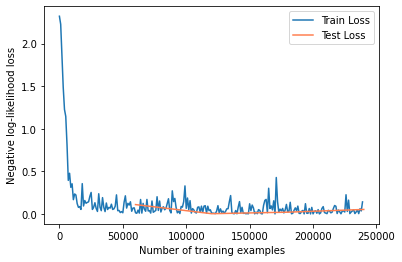

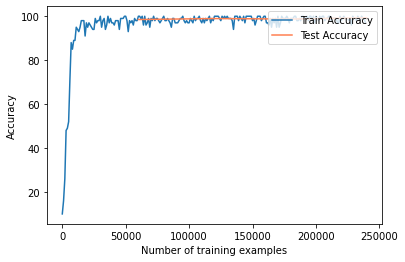

Train Epoch: 5/5 [0/60000 (0%)] Loss: 0.0025 Accuracy: 100.0000
Train Epoch: 5/5 [1000/60000 (2%)] Loss: 0.0176 Accuracy: 99.0000
Train Epoch: 5/5 [2000/60000 (3%)] Loss: 0.0096 Accuracy: 100.0000
Train Epoch: 5/5 [3000/60000 (5%)] Loss: 0.0316 Accuracy: 99.0000
Train Epoch: 5/5 [4000/60000 (7%)] Loss: 0.0346 Accuracy: 99.0000
Train Epoch: 5/5 [5000/60000 (8%)] Loss: 0.0055 Accuracy: 100.0000
Train Epoch: 5/5 [6000/60000 (10%)] Loss: 0.0230 Accuracy: 99.0000
Train Epoch: 5/5 [7000/60000 (12%)] Loss: 0.0592 Accuracy: 99.0000
Train Epoch: 5/5 [8000/60000 (13%)] Loss: 0.0002 Accuracy: 100.0000
Train Epoch: 5/5 [9000/60000 (15%)] Loss: 0.0055 Accuracy: 100.0000
Train Epoch: 5/5 [10000/60000 (17%)] Loss: 0.0015 Accuracy: 100.0000
Train Epoch: 5/5 [11000/60000 (18%)] Loss: 0.0005 Accuracy: 100.0000
Train Epoch: 5/5 [12000/60000 (20%)] Loss: 0.0016 Accuracy: 100.0000
Train Epoch: 5/5 [13000/60000 (22%)] Loss: 0.0342 Accuracy: 99.0000
Train Epoch: 5/5 [14000/60000 (23%)] Loss: 0.0460 Accuracy:

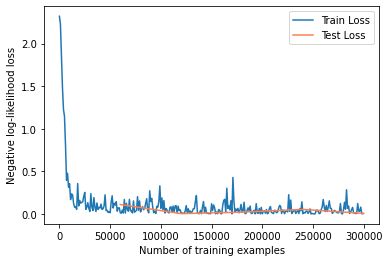

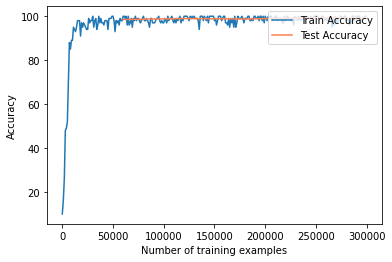

Total Time Takes 82.0557291507721.


In [ ]:
VGG11= VGG(config="VGG11").cuda()
fit(
   model=VGG11 ,
   name="VGG11_MNIST_NEW",
   train_loader=train_mnist,
   test_loader=test_mnist,
   epoches=5,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=False
)

# VGG13


Train Epoch: 1/5 [0/60000 (0%)] Loss: 2.2825 Accuracy: 19.0000
Train Epoch: 1/5 [1000/60000 (2%)] Loss: 2.1068 Accuracy: 15.0000
Train Epoch: 1/5 [2000/60000 (3%)] Loss: 1.7670 Accuracy: 21.0000
Train Epoch: 1/5 [3000/60000 (5%)] Loss: 1.6228 Accuracy: 31.0000
Train Epoch: 1/5 [4000/60000 (7%)] Loss: 1.4252 Accuracy: 33.0000
Train Epoch: 1/5 [5000/60000 (8%)] Loss: 1.3930 Accuracy: 42.0000
Train Epoch: 1/5 [6000/60000 (10%)] Loss: 1.2521 Accuracy: 50.0000
Train Epoch: 1/5 [7000/60000 (12%)] Loss: 1.2664 Accuracy: 51.0000
Train Epoch: 1/5 [8000/60000 (13%)] Loss: 1.0739 Accuracy: 49.0000
Train Epoch: 1/5 [9000/60000 (15%)] Loss: 1.1553 Accuracy: 49.0000
Train Epoch: 1/5 [10000/60000 (17%)] Loss: 0.9903 Accuracy: 68.0000
Train Epoch: 1/5 [11000/60000 (18%)] Loss: 0.8773 Accuracy: 67.0000
Train Epoch: 1/5 [12000/60000 (20%)] Loss: 0.7200 Accuracy: 73.0000
Train Epoch: 1/5 [13000/60000 (22%)] Loss: 0.7596 Accuracy: 72.0000
Train Epoch: 1/5 [14000/60000 (23%)] Loss: 0.4267 Accuracy: 84.0000

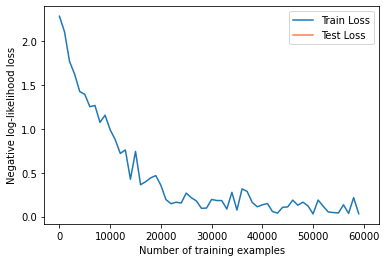

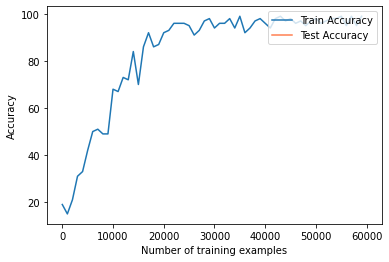

Train Epoch: 2/5 [0/60000 (0%)] Loss: 0.0667 Accuracy: 98.0000
Train Epoch: 2/5 [1000/60000 (2%)] Loss: 0.0835 Accuracy: 97.0000
Train Epoch: 2/5 [2000/60000 (3%)] Loss: 0.1661 Accuracy: 95.0000
Train Epoch: 2/5 [3000/60000 (5%)] Loss: 0.0662 Accuracy: 98.0000
Train Epoch: 2/5 [4000/60000 (7%)] Loss: 0.0477 Accuracy: 99.0000
Train Epoch: 2/5 [5000/60000 (8%)] Loss: 0.1848 Accuracy: 96.0000
Train Epoch: 2/5 [6000/60000 (10%)] Loss: 0.1837 Accuracy: 96.0000
Train Epoch: 2/5 [7000/60000 (12%)] Loss: 0.0942 Accuracy: 98.0000
Train Epoch: 2/5 [8000/60000 (13%)] Loss: 0.0678 Accuracy: 98.0000
Train Epoch: 2/5 [9000/60000 (15%)] Loss: 0.0227 Accuracy: 100.0000
Train Epoch: 2/5 [10000/60000 (17%)] Loss: 0.0568 Accuracy: 98.0000
Train Epoch: 2/5 [11000/60000 (18%)] Loss: 0.1191 Accuracy: 97.0000
Train Epoch: 2/5 [12000/60000 (20%)] Loss: 0.0533 Accuracy: 98.0000
Train Epoch: 2/5 [13000/60000 (22%)] Loss: 0.0576 Accuracy: 99.0000
Train Epoch: 2/5 [14000/60000 (23%)] Loss: 0.0800 Accuracy: 97.000

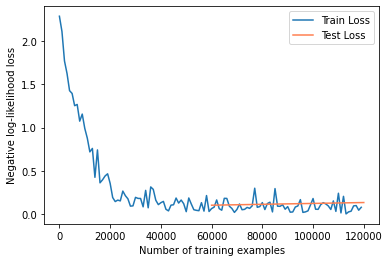

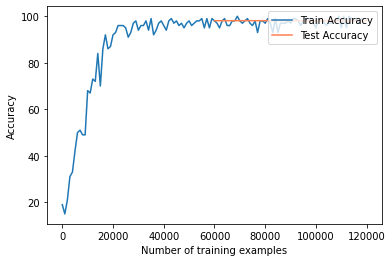

Train Epoch: 3/5 [0/60000 (0%)] Loss: 0.0118 Accuracy: 100.0000
Train Epoch: 3/5 [1000/60000 (2%)] Loss: 0.0982 Accuracy: 97.0000
Train Epoch: 3/5 [2000/60000 (3%)] Loss: 0.0655 Accuracy: 98.0000
Train Epoch: 3/5 [3000/60000 (5%)] Loss: 0.0518 Accuracy: 98.0000
Train Epoch: 3/5 [4000/60000 (7%)] Loss: 0.0294 Accuracy: 99.0000
Train Epoch: 3/5 [5000/60000 (8%)] Loss: 0.0335 Accuracy: 99.0000
Train Epoch: 3/5 [6000/60000 (10%)] Loss: 0.0436 Accuracy: 99.0000
Train Epoch: 3/5 [7000/60000 (12%)] Loss: 0.0447 Accuracy: 98.0000
Train Epoch: 3/5 [8000/60000 (13%)] Loss: 0.1863 Accuracy: 96.0000
Train Epoch: 3/5 [9000/60000 (15%)] Loss: 0.0220 Accuracy: 100.0000
Train Epoch: 3/5 [10000/60000 (17%)] Loss: 0.1062 Accuracy: 99.0000
Train Epoch: 3/5 [11000/60000 (18%)] Loss: 0.1165 Accuracy: 96.0000
Train Epoch: 3/5 [12000/60000 (20%)] Loss: 0.0677 Accuracy: 99.0000
Train Epoch: 3/5 [13000/60000 (22%)] Loss: 0.1202 Accuracy: 99.0000
Train Epoch: 3/5 [14000/60000 (23%)] Loss: 0.0952 Accuracy: 99.00

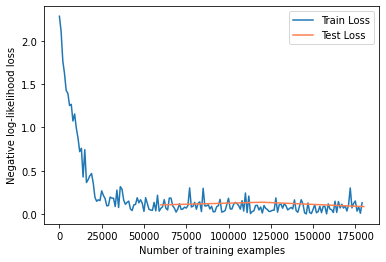

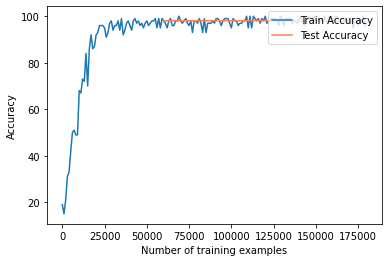

Train Epoch: 4/5 [0/60000 (0%)] Loss: 0.0471 Accuracy: 99.0000
Train Epoch: 4/5 [1000/60000 (2%)] Loss: 0.0459 Accuracy: 100.0000
Train Epoch: 4/5 [2000/60000 (3%)] Loss: 0.0030 Accuracy: 100.0000
Train Epoch: 4/5 [3000/60000 (5%)] Loss: 0.0035 Accuracy: 100.0000
Train Epoch: 4/5 [4000/60000 (7%)] Loss: 0.1032 Accuracy: 99.0000
Train Epoch: 4/5 [5000/60000 (8%)] Loss: 0.0050 Accuracy: 100.0000
Train Epoch: 4/5 [6000/60000 (10%)] Loss: 0.0080 Accuracy: 100.0000
Train Epoch: 4/5 [7000/60000 (12%)] Loss: 0.0122 Accuracy: 100.0000
Train Epoch: 4/5 [8000/60000 (13%)] Loss: 0.0875 Accuracy: 98.0000
Train Epoch: 4/5 [9000/60000 (15%)] Loss: 0.0660 Accuracy: 98.0000
Train Epoch: 4/5 [10000/60000 (17%)] Loss: 0.0231 Accuracy: 100.0000
Train Epoch: 4/5 [11000/60000 (18%)] Loss: 0.0384 Accuracy: 99.0000
Train Epoch: 4/5 [12000/60000 (20%)] Loss: 0.0106 Accuracy: 100.0000
Train Epoch: 4/5 [13000/60000 (22%)] Loss: 0.2314 Accuracy: 96.0000
Train Epoch: 4/5 [14000/60000 (23%)] Loss: 0.0407 Accuracy:

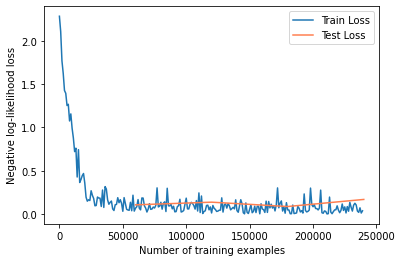

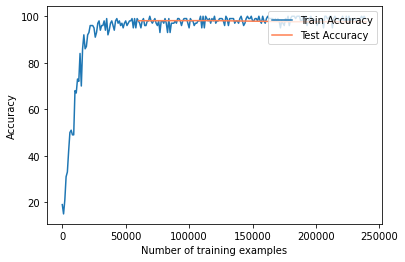

Train Epoch: 5/5 [0/60000 (0%)] Loss: 0.4644 Accuracy: 94.0000
Train Epoch: 5/5 [1000/60000 (2%)] Loss: 0.0548 Accuracy: 99.0000
Train Epoch: 5/5 [2000/60000 (3%)] Loss: 0.0151 Accuracy: 100.0000
Train Epoch: 5/5 [3000/60000 (5%)] Loss: 0.0411 Accuracy: 98.0000
Train Epoch: 5/5 [4000/60000 (7%)] Loss: 0.0451 Accuracy: 98.0000
Train Epoch: 5/5 [5000/60000 (8%)] Loss: 0.0115 Accuracy: 100.0000
Train Epoch: 5/5 [6000/60000 (10%)] Loss: 0.1663 Accuracy: 97.0000
Train Epoch: 5/5 [7000/60000 (12%)] Loss: 0.0379 Accuracy: 99.0000
Train Epoch: 5/5 [8000/60000 (13%)] Loss: 0.0293 Accuracy: 100.0000
Train Epoch: 5/5 [9000/60000 (15%)] Loss: 0.0295 Accuracy: 99.0000
Train Epoch: 5/5 [10000/60000 (17%)] Loss: 0.0230 Accuracy: 99.0000
Train Epoch: 5/5 [11000/60000 (18%)] Loss: 0.0210 Accuracy: 100.0000
Train Epoch: 5/5 [12000/60000 (20%)] Loss: 0.0059 Accuracy: 100.0000
Train Epoch: 5/5 [13000/60000 (22%)] Loss: 0.1222 Accuracy: 98.0000
Train Epoch: 5/5 [14000/60000 (23%)] Loss: 0.0847 Accuracy: 99

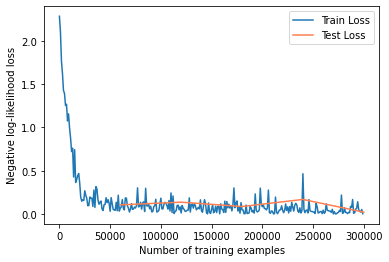

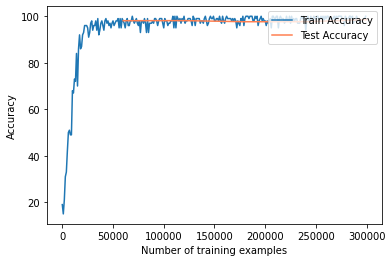

Total Time Takes 109.56097340583801.


In [ ]:
VGG13= VGG(config="VGG13").cuda()
fit(
   model=VGG13 ,
   name="VGG13_MNIST_NEW",
   train_loader=train_mnist,
   test_loader=test_mnist,
   epoches=5,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=False
)

# VGG16


Train Epoch: 1/5 [0/60000 (0%)] Loss: 2.3209 Accuracy: 11.0000
Train Epoch: 1/5 [1000/60000 (2%)] Loss: 2.1088 Accuracy: 18.0000
Train Epoch: 1/5 [2000/60000 (3%)] Loss: 2.1030 Accuracy: 15.0000
Train Epoch: 1/5 [3000/60000 (5%)] Loss: 1.9256 Accuracy: 23.0000
Train Epoch: 1/5 [4000/60000 (7%)] Loss: 1.8189 Accuracy: 19.0000
Train Epoch: 1/5 [5000/60000 (8%)] Loss: 1.6935 Accuracy: 26.0000
Train Epoch: 1/5 [6000/60000 (10%)] Loss: 1.6607 Accuracy: 37.0000
Train Epoch: 1/5 [7000/60000 (12%)] Loss: 1.5511 Accuracy: 38.0000
Train Epoch: 1/5 [8000/60000 (13%)] Loss: 1.5086 Accuracy: 42.0000
Train Epoch: 1/5 [9000/60000 (15%)] Loss: 1.4508 Accuracy: 32.0000
Train Epoch: 1/5 [10000/60000 (17%)] Loss: 1.3916 Accuracy: 37.0000
Train Epoch: 1/5 [11000/60000 (18%)] Loss: 1.4382 Accuracy: 42.0000
Train Epoch: 1/5 [12000/60000 (20%)] Loss: 1.4083 Accuracy: 34.0000
Train Epoch: 1/5 [13000/60000 (22%)] Loss: 1.6475 Accuracy: 37.0000
Train Epoch: 1/5 [14000/60000 (23%)] Loss: 1.1594 Accuracy: 49.0000

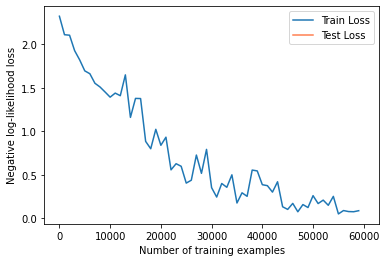

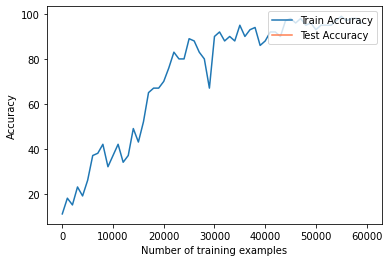

Train Epoch: 2/5 [0/60000 (0%)] Loss: 0.2821 Accuracy: 95.0000
Train Epoch: 2/5 [1000/60000 (2%)] Loss: 0.2539 Accuracy: 93.0000
Train Epoch: 2/5 [2000/60000 (3%)] Loss: 0.2764 Accuracy: 92.0000
Train Epoch: 2/5 [3000/60000 (5%)] Loss: 0.1936 Accuracy: 95.0000
Train Epoch: 2/5 [4000/60000 (7%)] Loss: 0.0805 Accuracy: 98.0000
Train Epoch: 2/5 [5000/60000 (8%)] Loss: 0.2098 Accuracy: 93.0000
Train Epoch: 2/5 [6000/60000 (10%)] Loss: 0.0799 Accuracy: 98.0000
Train Epoch: 2/5 [7000/60000 (12%)] Loss: 0.2165 Accuracy: 95.0000
Train Epoch: 2/5 [8000/60000 (13%)] Loss: 0.1693 Accuracy: 95.0000
Train Epoch: 2/5 [9000/60000 (15%)] Loss: 0.1966 Accuracy: 97.0000
Train Epoch: 2/5 [10000/60000 (17%)] Loss: 0.1250 Accuracy: 99.0000
Train Epoch: 2/5 [11000/60000 (18%)] Loss: 0.1507 Accuracy: 97.0000
Train Epoch: 2/5 [12000/60000 (20%)] Loss: 0.1167 Accuracy: 97.0000
Train Epoch: 2/5 [13000/60000 (22%)] Loss: 0.1151 Accuracy: 96.0000
Train Epoch: 2/5 [14000/60000 (23%)] Loss: 0.0932 Accuracy: 98.0000

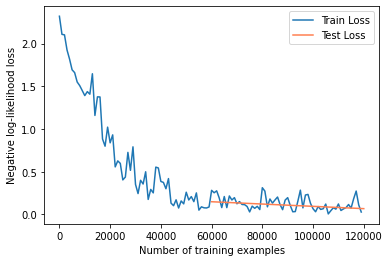

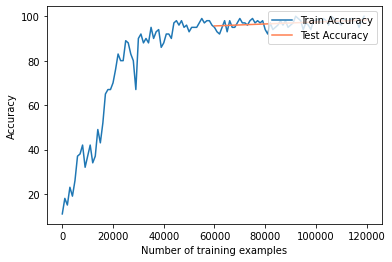

Train Epoch: 3/5 [0/60000 (0%)] Loss: 0.2321 Accuracy: 97.0000
Train Epoch: 3/5 [1000/60000 (2%)] Loss: 0.0487 Accuracy: 98.0000
Train Epoch: 3/5 [2000/60000 (3%)] Loss: 0.1631 Accuracy: 95.0000
Train Epoch: 3/5 [3000/60000 (5%)] Loss: 0.2469 Accuracy: 95.0000
Train Epoch: 3/5 [4000/60000 (7%)] Loss: 0.0563 Accuracy: 98.0000
Train Epoch: 3/5 [5000/60000 (8%)] Loss: 0.0942 Accuracy: 98.0000
Train Epoch: 3/5 [6000/60000 (10%)] Loss: 0.1533 Accuracy: 96.0000
Train Epoch: 3/5 [7000/60000 (12%)] Loss: 0.0145 Accuracy: 100.0000
Train Epoch: 3/5 [8000/60000 (13%)] Loss: 0.0927 Accuracy: 98.0000
Train Epoch: 3/5 [9000/60000 (15%)] Loss: 0.1641 Accuracy: 96.0000
Train Epoch: 3/5 [10000/60000 (17%)] Loss: 0.1932 Accuracy: 97.0000
Train Epoch: 3/5 [11000/60000 (18%)] Loss: 0.0205 Accuracy: 100.0000
Train Epoch: 3/5 [12000/60000 (20%)] Loss: 0.0398 Accuracy: 100.0000
Train Epoch: 3/5 [13000/60000 (22%)] Loss: 0.0429 Accuracy: 99.0000
Train Epoch: 3/5 [14000/60000 (23%)] Loss: 0.0699 Accuracy: 99.0

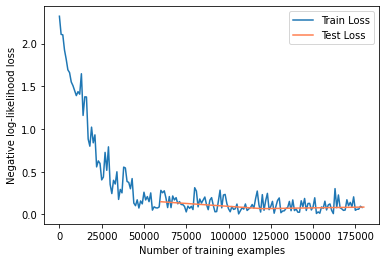

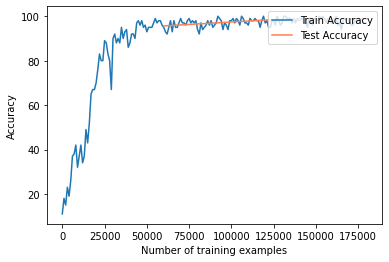

Train Epoch: 4/5 [0/60000 (0%)] Loss: 0.0337 Accuracy: 99.0000
Train Epoch: 4/5 [1000/60000 (2%)] Loss: 0.0406 Accuracy: 99.0000
Train Epoch: 4/5 [2000/60000 (3%)] Loss: 0.0578 Accuracy: 98.0000
Train Epoch: 4/5 [3000/60000 (5%)] Loss: 0.0610 Accuracy: 98.0000
Train Epoch: 4/5 [4000/60000 (7%)] Loss: 0.2227 Accuracy: 97.0000
Train Epoch: 4/5 [5000/60000 (8%)] Loss: 0.1781 Accuracy: 98.0000
Train Epoch: 4/5 [6000/60000 (10%)] Loss: 0.0665 Accuracy: 97.0000
Train Epoch: 4/5 [7000/60000 (12%)] Loss: 0.0379 Accuracy: 99.0000
Train Epoch: 4/5 [8000/60000 (13%)] Loss: 0.1192 Accuracy: 98.0000
Train Epoch: 4/5 [9000/60000 (15%)] Loss: 0.0777 Accuracy: 98.0000
Train Epoch: 4/5 [10000/60000 (17%)] Loss: 0.0314 Accuracy: 99.0000
Train Epoch: 4/5 [11000/60000 (18%)] Loss: 0.2224 Accuracy: 94.0000
Train Epoch: 4/5 [12000/60000 (20%)] Loss: 0.1289 Accuracy: 97.0000
Train Epoch: 4/5 [13000/60000 (22%)] Loss: 0.2300 Accuracy: 96.0000
Train Epoch: 4/5 [14000/60000 (23%)] Loss: 0.2323 Accuracy: 95.0000

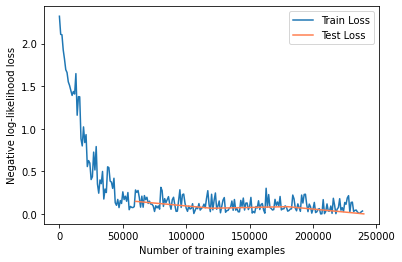

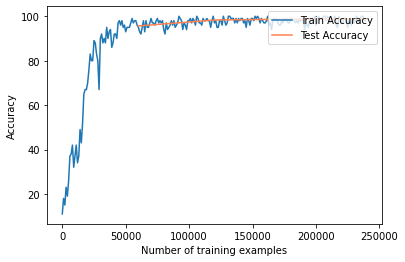

Train Epoch: 5/5 [0/60000 (0%)] Loss: 0.0235 Accuracy: 99.0000
Train Epoch: 5/5 [1000/60000 (2%)] Loss: 0.0201 Accuracy: 100.0000
Train Epoch: 5/5 [2000/60000 (3%)] Loss: 0.0090 Accuracy: 100.0000
Train Epoch: 5/5 [3000/60000 (5%)] Loss: 0.0496 Accuracy: 99.0000
Train Epoch: 5/5 [4000/60000 (7%)] Loss: 0.0595 Accuracy: 98.0000
Train Epoch: 5/5 [5000/60000 (8%)] Loss: 0.0403 Accuracy: 99.0000
Train Epoch: 5/5 [6000/60000 (10%)] Loss: 0.0917 Accuracy: 97.0000
Train Epoch: 5/5 [7000/60000 (12%)] Loss: 0.0558 Accuracy: 97.0000
Train Epoch: 5/5 [8000/60000 (13%)] Loss: 0.0721 Accuracy: 98.0000
Train Epoch: 5/5 [9000/60000 (15%)] Loss: 0.0250 Accuracy: 99.0000
Train Epoch: 5/5 [10000/60000 (17%)] Loss: 0.0190 Accuracy: 100.0000
Train Epoch: 5/5 [11000/60000 (18%)] Loss: 0.0177 Accuracy: 99.0000
Train Epoch: 5/5 [12000/60000 (20%)] Loss: 0.0231 Accuracy: 99.0000
Train Epoch: 5/5 [13000/60000 (22%)] Loss: 0.0488 Accuracy: 98.0000
Train Epoch: 5/5 [14000/60000 (23%)] Loss: 0.0784 Accuracy: 98.0

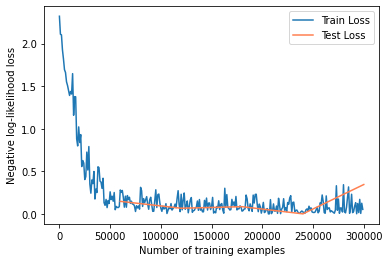

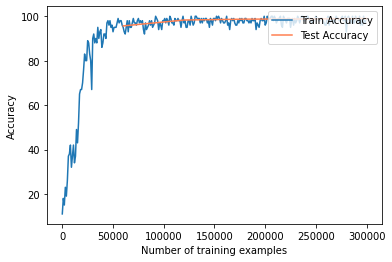

Total Time Takes 133.00164937973022.


In [ ]:
VGG16= VGG(config="VGG16").cuda()
fit(
   model=VGG16 ,
   name="VGG13_MNIST_NEW",
   train_loader=train_mnist,
   test_loader=test_mnist,
   epoches=5,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=False
)

# VGG19


Train Epoch: 1/5 [0/60000 (0%)] Loss: 2.3482 Accuracy: 13.0000
Train Epoch: 1/5 [1000/60000 (2%)] Loss: 2.2402 Accuracy: 15.0000
Train Epoch: 1/5 [2000/60000 (3%)] Loss: 1.9705 Accuracy: 20.0000
Train Epoch: 1/5 [3000/60000 (5%)] Loss: 1.7009 Accuracy: 30.0000
Train Epoch: 1/5 [4000/60000 (7%)] Loss: 1.5705 Accuracy: 38.0000
Train Epoch: 1/5 [5000/60000 (8%)] Loss: 1.4034 Accuracy: 44.0000
Train Epoch: 1/5 [6000/60000 (10%)] Loss: 1.4851 Accuracy: 38.0000
Train Epoch: 1/5 [7000/60000 (12%)] Loss: 1.4825 Accuracy: 32.0000
Train Epoch: 1/5 [8000/60000 (13%)] Loss: 1.1611 Accuracy: 59.0000
Train Epoch: 1/5 [9000/60000 (15%)] Loss: 1.5952 Accuracy: 45.0000
Train Epoch: 1/5 [10000/60000 (17%)] Loss: 1.2661 Accuracy: 41.0000
Train Epoch: 1/5 [11000/60000 (18%)] Loss: 1.1834 Accuracy: 48.0000
Train Epoch: 1/5 [12000/60000 (20%)] Loss: 1.1691 Accuracy: 52.0000
Train Epoch: 1/5 [13000/60000 (22%)] Loss: 1.0934 Accuracy: 56.0000
Train Epoch: 1/5 [14000/60000 (23%)] Loss: 1.0441 Accuracy: 59.0000

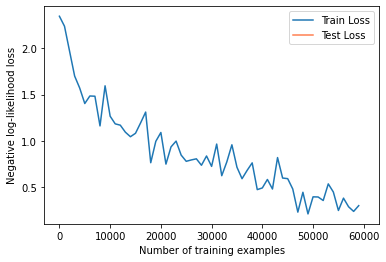

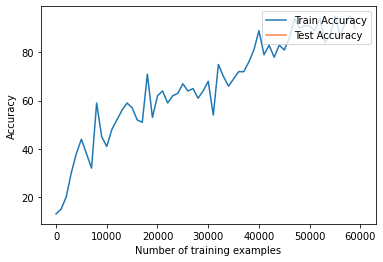

Train Epoch: 2/5 [0/60000 (0%)] Loss: 0.2145 Accuracy: 95.0000
Train Epoch: 2/5 [1000/60000 (2%)] Loss: 0.4954 Accuracy: 93.0000
Train Epoch: 2/5 [2000/60000 (3%)] Loss: 0.4996 Accuracy: 89.0000
Train Epoch: 2/5 [3000/60000 (5%)] Loss: 0.2354 Accuracy: 94.0000
Train Epoch: 2/5 [4000/60000 (7%)] Loss: 0.2107 Accuracy: 96.0000
Train Epoch: 2/5 [5000/60000 (8%)] Loss: 0.1498 Accuracy: 93.0000
Train Epoch: 2/5 [6000/60000 (10%)] Loss: 0.1936 Accuracy: 96.0000
Train Epoch: 2/5 [7000/60000 (12%)] Loss: 0.1800 Accuracy: 93.0000
Train Epoch: 2/5 [8000/60000 (13%)] Loss: 0.2250 Accuracy: 93.0000
Train Epoch: 2/5 [9000/60000 (15%)] Loss: 0.2724 Accuracy: 93.0000
Train Epoch: 2/5 [10000/60000 (17%)] Loss: 0.2173 Accuracy: 96.0000
Train Epoch: 2/5 [11000/60000 (18%)] Loss: 0.0915 Accuracy: 98.0000
Train Epoch: 2/5 [12000/60000 (20%)] Loss: 0.3285 Accuracy: 92.0000
Train Epoch: 2/5 [13000/60000 (22%)] Loss: 0.1889 Accuracy: 94.0000
Train Epoch: 2/5 [14000/60000 (23%)] Loss: 0.2768 Accuracy: 93.0000

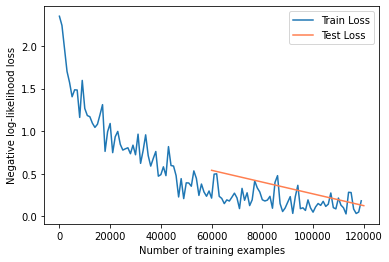

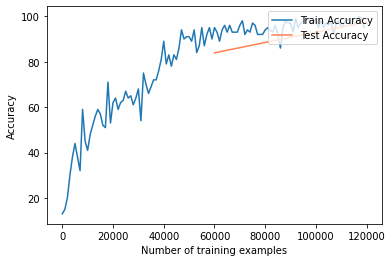

Train Epoch: 3/5 [0/60000 (0%)] Loss: 0.0585 Accuracy: 98.0000
Train Epoch: 3/5 [1000/60000 (2%)] Loss: 0.1420 Accuracy: 97.0000
Train Epoch: 3/5 [2000/60000 (3%)] Loss: 0.1211 Accuracy: 97.0000
Train Epoch: 3/5 [3000/60000 (5%)] Loss: 0.1751 Accuracy: 96.0000
Train Epoch: 3/5 [4000/60000 (7%)] Loss: 0.3249 Accuracy: 93.0000
Train Epoch: 3/5 [5000/60000 (8%)] Loss: 0.0910 Accuracy: 98.0000
Train Epoch: 3/5 [6000/60000 (10%)] Loss: 0.1038 Accuracy: 98.0000
Train Epoch: 3/5 [7000/60000 (12%)] Loss: 0.0700 Accuracy: 98.0000
Train Epoch: 3/5 [8000/60000 (13%)] Loss: 0.0827 Accuracy: 98.0000
Train Epoch: 3/5 [9000/60000 (15%)] Loss: 0.1142 Accuracy: 96.0000
Train Epoch: 3/5 [10000/60000 (17%)] Loss: 0.3253 Accuracy: 96.0000
Train Epoch: 3/5 [11000/60000 (18%)] Loss: 0.0493 Accuracy: 98.0000
Train Epoch: 3/5 [12000/60000 (20%)] Loss: 0.0048 Accuracy: 100.0000
Train Epoch: 3/5 [13000/60000 (22%)] Loss: 0.0746 Accuracy: 98.0000
Train Epoch: 3/5 [14000/60000 (23%)] Loss: 0.0239 Accuracy: 99.000

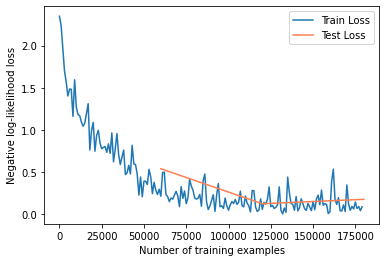

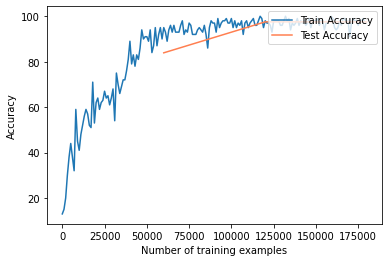

Train Epoch: 4/5 [0/60000 (0%)] Loss: 0.1160 Accuracy: 95.0000
Train Epoch: 4/5 [1000/60000 (2%)] Loss: 0.0313 Accuracy: 100.0000
Train Epoch: 4/5 [2000/60000 (3%)] Loss: 0.1249 Accuracy: 96.0000
Train Epoch: 4/5 [3000/60000 (5%)] Loss: 0.0861 Accuracy: 97.0000
Train Epoch: 4/5 [4000/60000 (7%)] Loss: 0.1209 Accuracy: 96.0000
Train Epoch: 4/5 [5000/60000 (8%)] Loss: 0.0779 Accuracy: 98.0000
Train Epoch: 4/5 [6000/60000 (10%)] Loss: 0.0144 Accuracy: 100.0000
Train Epoch: 4/5 [7000/60000 (12%)] Loss: 0.0616 Accuracy: 98.0000
Train Epoch: 4/5 [8000/60000 (13%)] Loss: 0.0167 Accuracy: 100.0000
Train Epoch: 4/5 [9000/60000 (15%)] Loss: 0.0562 Accuracy: 99.0000
Train Epoch: 4/5 [10000/60000 (17%)] Loss: 0.0289 Accuracy: 99.0000
Train Epoch: 4/5 [11000/60000 (18%)] Loss: 0.1305 Accuracy: 98.0000
Train Epoch: 4/5 [12000/60000 (20%)] Loss: 0.0752 Accuracy: 98.0000
Train Epoch: 4/5 [13000/60000 (22%)] Loss: 0.1614 Accuracy: 97.0000
Train Epoch: 4/5 [14000/60000 (23%)] Loss: 0.0131 Accuracy: 100.

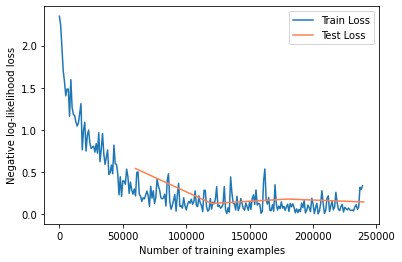

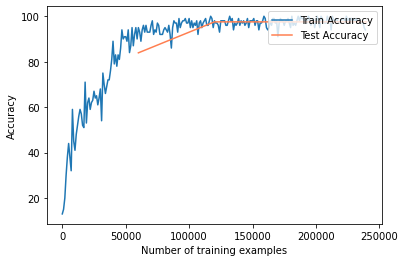

Train Epoch: 5/5 [0/60000 (0%)] Loss: 0.1276 Accuracy: 97.0000
Train Epoch: 5/5 [1000/60000 (2%)] Loss: 0.0150 Accuracy: 100.0000
Train Epoch: 5/5 [2000/60000 (3%)] Loss: 0.0257 Accuracy: 99.0000
Train Epoch: 5/5 [3000/60000 (5%)] Loss: 0.0437 Accuracy: 99.0000
Train Epoch: 5/5 [4000/60000 (7%)] Loss: 0.0371 Accuracy: 99.0000
Train Epoch: 5/5 [5000/60000 (8%)] Loss: 0.0695 Accuracy: 99.0000
Train Epoch: 5/5 [6000/60000 (10%)] Loss: 0.2042 Accuracy: 97.0000
Train Epoch: 5/5 [7000/60000 (12%)] Loss: 0.0809 Accuracy: 97.0000
Train Epoch: 5/5 [8000/60000 (13%)] Loss: 0.0339 Accuracy: 100.0000
Train Epoch: 5/5 [9000/60000 (15%)] Loss: 0.0193 Accuracy: 100.0000
Train Epoch: 5/5 [10000/60000 (17%)] Loss: 0.2329 Accuracy: 98.0000
Train Epoch: 5/5 [11000/60000 (18%)] Loss: 0.0323 Accuracy: 99.0000
Train Epoch: 5/5 [12000/60000 (20%)] Loss: 0.0282 Accuracy: 99.0000
Train Epoch: 5/5 [13000/60000 (22%)] Loss: 0.1523 Accuracy: 96.0000
Train Epoch: 5/5 [14000/60000 (23%)] Loss: 0.0609 Accuracy: 98.0

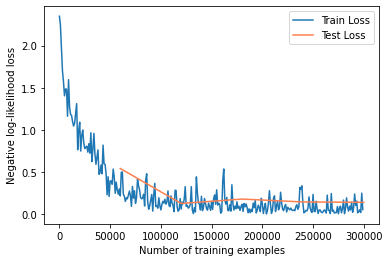

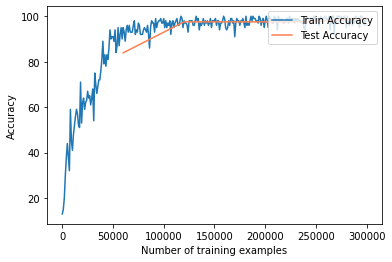

Total Time Takes 156.20036840438843.


In [ ]:
VGG19= VGG(config="VGG19").cuda()
fit(
   model=VGG19 ,
   name="VGG19_MNIST_NEW",
   train_loader=train_mnist,
   test_loader=test_mnist,
   epoches=5,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=False
)

# ResNet18


Train Epoch: 1/5 [0/60000 (0%)] Loss: 2.3773 Accuracy: 7.0000
Train Epoch: 1/5 [1000/60000 (2%)] Loss: 0.2985 Accuracy: 89.0000
Train Epoch: 1/5 [2000/60000 (3%)] Loss: 0.0872 Accuracy: 98.0000
Train Epoch: 1/5 [3000/60000 (5%)] Loss: 0.1433 Accuracy: 96.0000
Train Epoch: 1/5 [4000/60000 (7%)] Loss: 0.1332 Accuracy: 98.0000
Train Epoch: 1/5 [5000/60000 (8%)] Loss: 0.2271 Accuracy: 95.0000
Train Epoch: 1/5 [6000/60000 (10%)] Loss: 0.0755 Accuracy: 96.0000
Train Epoch: 1/5 [7000/60000 (12%)] Loss: 0.1754 Accuracy: 94.0000
Train Epoch: 1/5 [8000/60000 (13%)] Loss: 0.2302 Accuracy: 94.0000
Train Epoch: 1/5 [9000/60000 (15%)] Loss: 0.1681 Accuracy: 96.0000
Train Epoch: 1/5 [10000/60000 (17%)] Loss: 0.1897 Accuracy: 94.0000
Train Epoch: 1/5 [11000/60000 (18%)] Loss: 0.0987 Accuracy: 96.0000
Train Epoch: 1/5 [12000/60000 (20%)] Loss: 0.1848 Accuracy: 95.0000
Train Epoch: 1/5 [13000/60000 (22%)] Loss: 0.1852 Accuracy: 93.0000
Train Epoch: 1/5 [14000/60000 (23%)] Loss: 0.1329 Accuracy: 97.0000


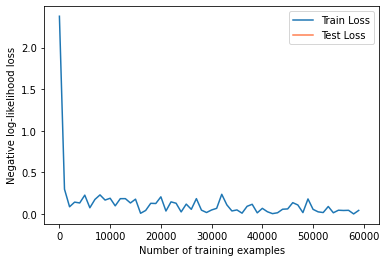

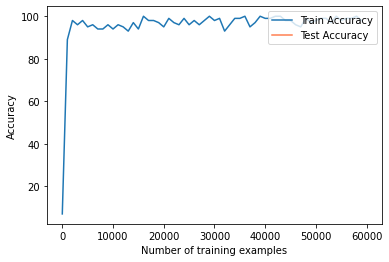

Train Epoch: 2/5 [0/60000 (0%)] Loss: 0.0393 Accuracy: 99.0000
Train Epoch: 2/5 [1000/60000 (2%)] Loss: 0.0535 Accuracy: 99.0000
Train Epoch: 2/5 [2000/60000 (3%)] Loss: 0.0536 Accuracy: 98.0000
Train Epoch: 2/5 [3000/60000 (5%)] Loss: 0.1664 Accuracy: 97.0000
Train Epoch: 2/5 [4000/60000 (7%)] Loss: 0.0252 Accuracy: 100.0000
Train Epoch: 2/5 [5000/60000 (8%)] Loss: 0.0983 Accuracy: 97.0000
Train Epoch: 2/5 [6000/60000 (10%)] Loss: 0.0346 Accuracy: 99.0000
Train Epoch: 2/5 [7000/60000 (12%)] Loss: 0.0095 Accuracy: 100.0000
Train Epoch: 2/5 [8000/60000 (13%)] Loss: 0.0244 Accuracy: 99.0000
Train Epoch: 2/5 [9000/60000 (15%)] Loss: 0.0273 Accuracy: 98.0000
Train Epoch: 2/5 [10000/60000 (17%)] Loss: 0.0337 Accuracy: 99.0000
Train Epoch: 2/5 [11000/60000 (18%)] Loss: 0.0579 Accuracy: 98.0000
Train Epoch: 2/5 [12000/60000 (20%)] Loss: 0.0296 Accuracy: 99.0000
Train Epoch: 2/5 [13000/60000 (22%)] Loss: 0.0579 Accuracy: 97.0000
Train Epoch: 2/5 [14000/60000 (23%)] Loss: 0.0100 Accuracy: 100.0

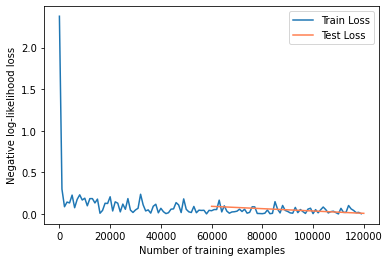

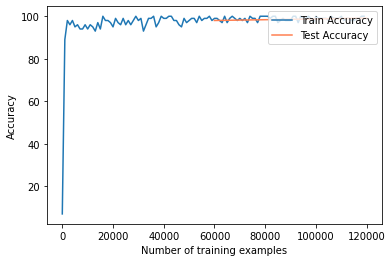

Train Epoch: 3/5 [0/60000 (0%)] Loss: 0.0017 Accuracy: 100.0000
Train Epoch: 3/5 [1000/60000 (2%)] Loss: 0.0043 Accuracy: 100.0000
Train Epoch: 3/5 [2000/60000 (3%)] Loss: 0.0071 Accuracy: 100.0000
Train Epoch: 3/5 [3000/60000 (5%)] Loss: 0.0151 Accuracy: 99.0000
Train Epoch: 3/5 [4000/60000 (7%)] Loss: 0.0018 Accuracy: 100.0000
Train Epoch: 3/5 [5000/60000 (8%)] Loss: 0.0442 Accuracy: 98.0000
Train Epoch: 3/5 [6000/60000 (10%)] Loss: 0.0632 Accuracy: 98.0000
Train Epoch: 3/5 [7000/60000 (12%)] Loss: 0.0229 Accuracy: 99.0000
Train Epoch: 3/5 [8000/60000 (13%)] Loss: 0.0227 Accuracy: 99.0000
Train Epoch: 3/5 [9000/60000 (15%)] Loss: 0.0718 Accuracy: 98.0000
Train Epoch: 3/5 [10000/60000 (17%)] Loss: 0.0920 Accuracy: 98.0000
Train Epoch: 3/5 [11000/60000 (18%)] Loss: 0.0140 Accuracy: 100.0000
Train Epoch: 3/5 [12000/60000 (20%)] Loss: 0.0162 Accuracy: 99.0000
Train Epoch: 3/5 [13000/60000 (22%)] Loss: 0.0245 Accuracy: 99.0000
Train Epoch: 3/5 [14000/60000 (23%)] Loss: 0.0622 Accuracy: 98

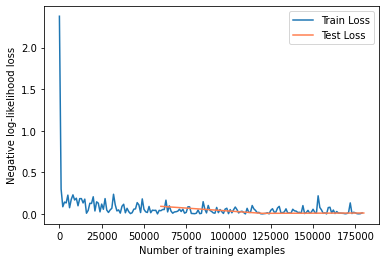

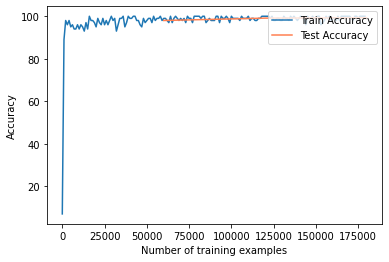

Train Epoch: 4/5 [0/60000 (0%)] Loss: 0.0959 Accuracy: 99.0000
Train Epoch: 4/5 [1000/60000 (2%)] Loss: 0.0130 Accuracy: 100.0000
Train Epoch: 4/5 [2000/60000 (3%)] Loss: 0.0076 Accuracy: 100.0000
Train Epoch: 4/5 [3000/60000 (5%)] Loss: 0.0017 Accuracy: 100.0000
Train Epoch: 4/5 [4000/60000 (7%)] Loss: 0.0014 Accuracy: 100.0000
Train Epoch: 4/5 [5000/60000 (8%)] Loss: 0.0133 Accuracy: 99.0000
Train Epoch: 4/5 [6000/60000 (10%)] Loss: 0.0532 Accuracy: 99.0000
Train Epoch: 4/5 [7000/60000 (12%)] Loss: 0.0635 Accuracy: 97.0000
Train Epoch: 4/5 [8000/60000 (13%)] Loss: 0.0219 Accuracy: 99.0000
Train Epoch: 4/5 [9000/60000 (15%)] Loss: 0.0066 Accuracy: 100.0000
Train Epoch: 4/5 [10000/60000 (17%)] Loss: 0.0207 Accuracy: 99.0000
Train Epoch: 4/5 [11000/60000 (18%)] Loss: 0.0061 Accuracy: 100.0000
Train Epoch: 4/5 [12000/60000 (20%)] Loss: 0.0048 Accuracy: 100.0000
Train Epoch: 4/5 [13000/60000 (22%)] Loss: 0.0217 Accuracy: 99.0000
Train Epoch: 4/5 [14000/60000 (23%)] Loss: 0.0129 Accuracy: 

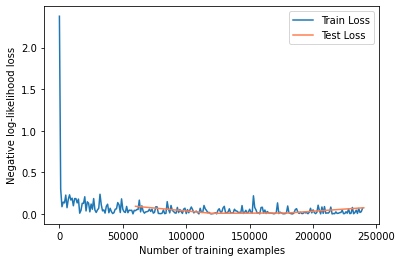

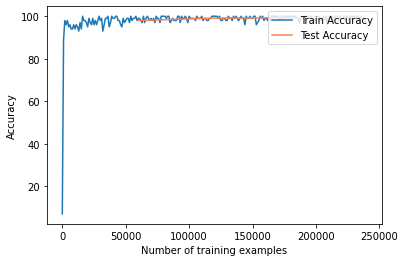

Train Epoch: 5/5 [0/60000 (0%)] Loss: 0.0561 Accuracy: 98.0000
Train Epoch: 5/5 [1000/60000 (2%)] Loss: 0.0043 Accuracy: 100.0000
Train Epoch: 5/5 [2000/60000 (3%)] Loss: 0.0742 Accuracy: 98.0000
Train Epoch: 5/5 [3000/60000 (5%)] Loss: 0.0033 Accuracy: 100.0000
Train Epoch: 5/5 [4000/60000 (7%)] Loss: 0.0136 Accuracy: 99.0000
Train Epoch: 5/5 [5000/60000 (8%)] Loss: 0.0012 Accuracy: 100.0000
Train Epoch: 5/5 [6000/60000 (10%)] Loss: 0.0046 Accuracy: 100.0000
Train Epoch: 5/5 [7000/60000 (12%)] Loss: 0.0011 Accuracy: 100.0000
Train Epoch: 5/5 [8000/60000 (13%)] Loss: 0.0066 Accuracy: 100.0000
Train Epoch: 5/5 [9000/60000 (15%)] Loss: 0.0419 Accuracy: 99.0000
Train Epoch: 5/5 [10000/60000 (17%)] Loss: 0.0505 Accuracy: 98.0000
Train Epoch: 5/5 [11000/60000 (18%)] Loss: 0.0105 Accuracy: 100.0000
Train Epoch: 5/5 [12000/60000 (20%)] Loss: 0.0055 Accuracy: 100.0000
Train Epoch: 5/5 [13000/60000 (22%)] Loss: 0.0036 Accuracy: 100.0000
Train Epoch: 5/5 [14000/60000 (23%)] Loss: 0.0006 Accuracy

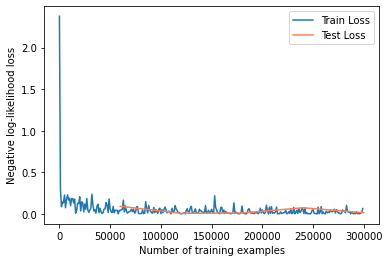

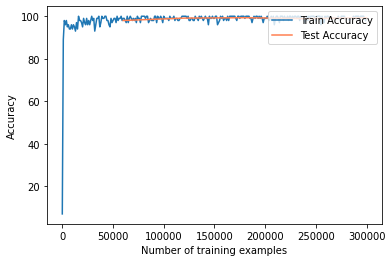

Total Time Takes 111.15094780921936.


In [ ]:
ResNet18 = ResNet(config="resnet18", in_channels=1, num_classes=10).cuda()
fit(
   model=ResNet18 ,
   name="VGG11_MNIST_NEW",
   train_loader=train_mnist,
   test_loader=test_mnist,
   epoches=5,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=False
)

# ResNet34

Train Epoch: 1/5 [0/60000 (0%)] Loss: 2.4144 Accuracy: 10.0000
Train Epoch: 1/5 [1000/60000 (2%)] Loss: 0.4962 Accuracy: 82.0000
Train Epoch: 1/5 [2000/60000 (3%)] Loss: 0.4161 Accuracy: 87.0000
Train Epoch: 1/5 [3000/60000 (5%)] Loss: 0.1932 Accuracy: 95.0000
Train Epoch: 1/5 [4000/60000 (7%)] Loss: 0.2139 Accuracy: 94.0000
Train Epoch: 1/5 [5000/60000 (8%)] Loss: 0.3095 Accuracy: 90.0000
Train Epoch: 1/5 [6000/60000 (10%)] Loss: 0.1111 Accuracy: 98.0000
Train Epoch: 1/5 [7000/60000 (12%)] Loss: 0.1680 Accuracy: 94.0000
Train Epoch: 1/5 [8000/60000 (13%)] Loss: 0.2774 Accuracy: 90.0000
Train Epoch: 1/5 [9000/60000 (15%)] Loss: 0.2283 Accuracy: 96.0000
Train Epoch: 1/5 [10000/60000 (17%)] Loss: 0.1262 Accuracy: 98.0000
Train Epoch: 1/5 [11000/60000 (18%)] Loss: 0.1215 Accuracy: 97.0000
Train Epoch: 1/5 [12000/60000 (20%)] Loss: 0.1998 Accuracy: 95.0000
Train Epoch: 1/5 [13000/60000 (22%)] Loss: 0.0895 Accuracy: 97.0000
Train Epoch: 1/5 [14000/60000 (23%)] Loss: 0.1565 Accuracy: 93.0000

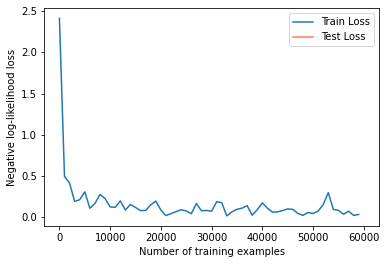

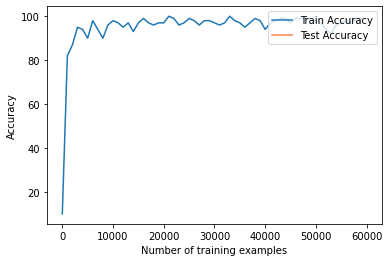

Train Epoch: 2/5 [0/60000 (0%)] Loss: 0.1324 Accuracy: 97.0000
Train Epoch: 2/5 [1000/60000 (2%)] Loss: 0.1132 Accuracy: 95.0000
Train Epoch: 2/5 [2000/60000 (3%)] Loss: 0.0701 Accuracy: 98.0000
Train Epoch: 2/5 [3000/60000 (5%)] Loss: 0.1403 Accuracy: 97.0000
Train Epoch: 2/5 [4000/60000 (7%)] Loss: 0.0586 Accuracy: 98.0000
Train Epoch: 2/5 [5000/60000 (8%)] Loss: 0.0083 Accuracy: 100.0000
Train Epoch: 2/5 [6000/60000 (10%)] Loss: 0.0864 Accuracy: 96.0000
Train Epoch: 2/5 [7000/60000 (12%)] Loss: 0.0153 Accuracy: 100.0000
Train Epoch: 2/5 [8000/60000 (13%)] Loss: 0.0419 Accuracy: 98.0000
Train Epoch: 2/5 [9000/60000 (15%)] Loss: 0.1298 Accuracy: 96.0000
Train Epoch: 2/5 [10000/60000 (17%)] Loss: 0.0713 Accuracy: 98.0000
Train Epoch: 2/5 [11000/60000 (18%)] Loss: 0.0239 Accuracy: 99.0000
Train Epoch: 2/5 [12000/60000 (20%)] Loss: 0.1412 Accuracy: 95.0000
Train Epoch: 2/5 [13000/60000 (22%)] Loss: 0.0179 Accuracy: 99.0000
Train Epoch: 2/5 [14000/60000 (23%)] Loss: 0.0106 Accuracy: 100.0

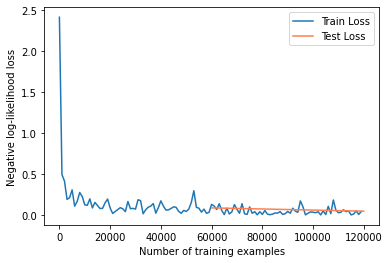

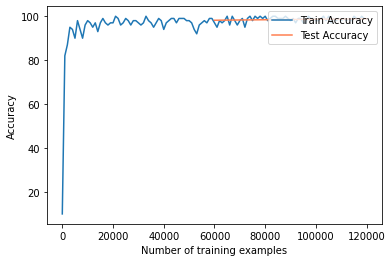

Train Epoch: 3/5 [0/60000 (0%)] Loss: 0.0680 Accuracy: 99.0000
Train Epoch: 3/5 [1000/60000 (2%)] Loss: 0.0082 Accuracy: 100.0000
Train Epoch: 3/5 [2000/60000 (3%)] Loss: 0.0078 Accuracy: 100.0000
Train Epoch: 3/5 [3000/60000 (5%)] Loss: 0.0033 Accuracy: 100.0000
Train Epoch: 3/5 [4000/60000 (7%)] Loss: 0.0290 Accuracy: 99.0000
Train Epoch: 3/5 [5000/60000 (8%)] Loss: 0.0205 Accuracy: 100.0000
Train Epoch: 3/5 [6000/60000 (10%)] Loss: 0.0107 Accuracy: 100.0000
Train Epoch: 3/5 [7000/60000 (12%)] Loss: 0.0228 Accuracy: 99.0000
Train Epoch: 3/5 [8000/60000 (13%)] Loss: 0.0291 Accuracy: 99.0000
Train Epoch: 3/5 [9000/60000 (15%)] Loss: 0.0399 Accuracy: 98.0000
Train Epoch: 3/5 [10000/60000 (17%)] Loss: 0.0103 Accuracy: 100.0000
Train Epoch: 3/5 [11000/60000 (18%)] Loss: 0.0268 Accuracy: 99.0000
Train Epoch: 3/5 [12000/60000 (20%)] Loss: 0.0455 Accuracy: 99.0000
Train Epoch: 3/5 [13000/60000 (22%)] Loss: 0.0127 Accuracy: 99.0000
Train Epoch: 3/5 [14000/60000 (23%)] Loss: 0.0069 Accuracy: 1

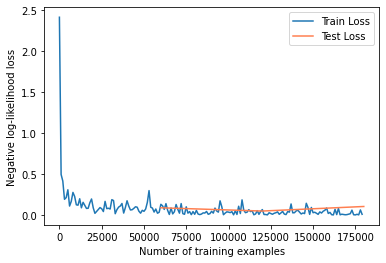

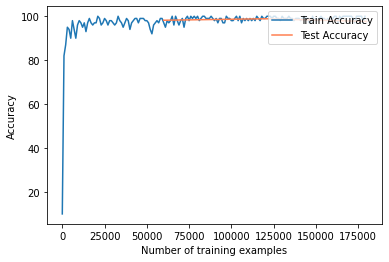

Train Epoch: 4/5 [0/60000 (0%)] Loss: 0.0816 Accuracy: 98.0000
Train Epoch: 4/5 [1000/60000 (2%)] Loss: 0.0042 Accuracy: 100.0000
Train Epoch: 4/5 [2000/60000 (3%)] Loss: 0.0287 Accuracy: 98.0000
Train Epoch: 4/5 [3000/60000 (5%)] Loss: 0.1753 Accuracy: 95.0000
Train Epoch: 4/5 [4000/60000 (7%)] Loss: 0.0063 Accuracy: 100.0000
Train Epoch: 4/5 [5000/60000 (8%)] Loss: 0.0616 Accuracy: 98.0000
Train Epoch: 4/5 [6000/60000 (10%)] Loss: 0.0048 Accuracy: 100.0000
Train Epoch: 4/5 [7000/60000 (12%)] Loss: 0.0260 Accuracy: 99.0000
Train Epoch: 4/5 [8000/60000 (13%)] Loss: 0.1667 Accuracy: 97.0000
Train Epoch: 4/5 [9000/60000 (15%)] Loss: 0.0266 Accuracy: 99.0000
Train Epoch: 4/5 [10000/60000 (17%)] Loss: 0.0226 Accuracy: 99.0000
Train Epoch: 4/5 [11000/60000 (18%)] Loss: 0.0010 Accuracy: 100.0000
Train Epoch: 4/5 [12000/60000 (20%)] Loss: 0.0565 Accuracy: 97.0000
Train Epoch: 4/5 [13000/60000 (22%)] Loss: 0.0279 Accuracy: 99.0000
Train Epoch: 4/5 [14000/60000 (23%)] Loss: 0.0041 Accuracy: 100

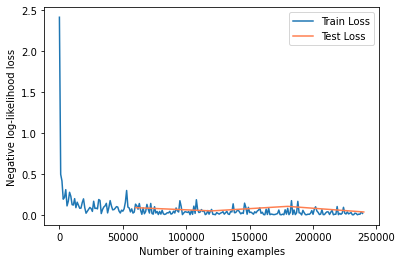

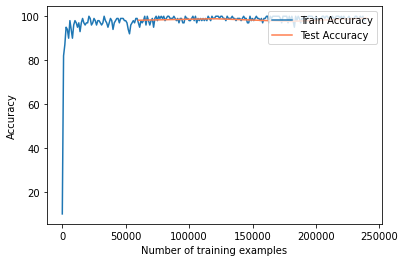

Train Epoch: 5/5 [0/60000 (0%)] Loss: 0.0281 Accuracy: 98.0000
Train Epoch: 5/5 [1000/60000 (2%)] Loss: 0.0072 Accuracy: 100.0000
Train Epoch: 5/5 [2000/60000 (3%)] Loss: 0.0149 Accuracy: 100.0000
Train Epoch: 5/5 [3000/60000 (5%)] Loss: 0.0122 Accuracy: 99.0000
Train Epoch: 5/5 [4000/60000 (7%)] Loss: 0.0049 Accuracy: 100.0000
Train Epoch: 5/5 [5000/60000 (8%)] Loss: 0.0185 Accuracy: 99.0000
Train Epoch: 5/5 [6000/60000 (10%)] Loss: 0.0929 Accuracy: 99.0000
Train Epoch: 5/5 [7000/60000 (12%)] Loss: 0.0023 Accuracy: 100.0000
Train Epoch: 5/5 [8000/60000 (13%)] Loss: 0.0100 Accuracy: 100.0000
Train Epoch: 5/5 [9000/60000 (15%)] Loss: 0.0060 Accuracy: 100.0000
Train Epoch: 5/5 [10000/60000 (17%)] Loss: 0.0232 Accuracy: 99.0000
Train Epoch: 5/5 [11000/60000 (18%)] Loss: 0.0213 Accuracy: 99.0000
Train Epoch: 5/5 [12000/60000 (20%)] Loss: 0.0175 Accuracy: 100.0000
Train Epoch: 5/5 [13000/60000 (22%)] Loss: 0.0112 Accuracy: 99.0000
Train Epoch: 5/5 [14000/60000 (23%)] Loss: 0.0015 Accuracy: 

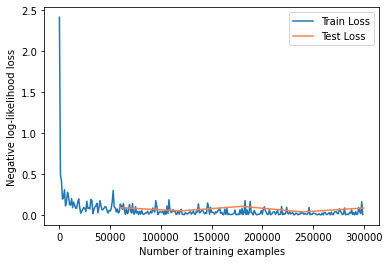

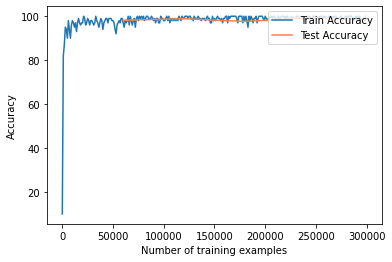

Total Time Takes 177.8830645084381.


In [ ]:
ResNet34 = ResNet(config="resnet34", in_channels=1, num_classes=10).cuda()
fit(
   model=ResNet34,
   name="VGG11_MNIST_NEW",
   train_loader=train_mnist,
   test_loader=test_mnist,
   epoches=5,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=False
)

# ResNet50

Train Epoch: 1/5 [0/60000 (0%)] Loss: 2.4928 Accuracy: 17.0000
Train Epoch: 1/5 [1000/60000 (2%)] Loss: 0.8212 Accuracy: 72.0000
Train Epoch: 1/5 [2000/60000 (3%)] Loss: 0.6456 Accuracy: 75.0000
Train Epoch: 1/5 [3000/60000 (5%)] Loss: 0.2560 Accuracy: 92.0000
Train Epoch: 1/5 [4000/60000 (7%)] Loss: 0.2245 Accuracy: 92.0000
Train Epoch: 1/5 [5000/60000 (8%)] Loss: 0.4297 Accuracy: 86.0000
Train Epoch: 1/5 [6000/60000 (10%)] Loss: 0.2228 Accuracy: 94.0000
Train Epoch: 1/5 [7000/60000 (12%)] Loss: 0.2392 Accuracy: 92.0000
Train Epoch: 1/5 [8000/60000 (13%)] Loss: 0.3278 Accuracy: 87.0000
Train Epoch: 1/5 [9000/60000 (15%)] Loss: 0.3920 Accuracy: 90.0000
Train Epoch: 1/5 [10000/60000 (17%)] Loss: 0.1171 Accuracy: 96.0000
Train Epoch: 1/5 [11000/60000 (18%)] Loss: 0.0949 Accuracy: 96.0000
Train Epoch: 1/5 [12000/60000 (20%)] Loss: 0.2470 Accuracy: 94.0000
Train Epoch: 1/5 [13000/60000 (22%)] Loss: 0.0896 Accuracy: 97.0000
Train Epoch: 1/5 [14000/60000 (23%)] Loss: 0.0986 Accuracy: 97.0000

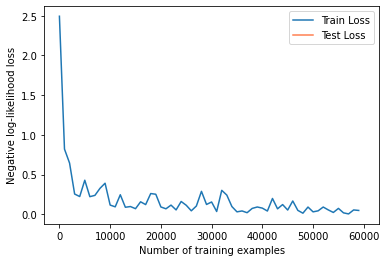

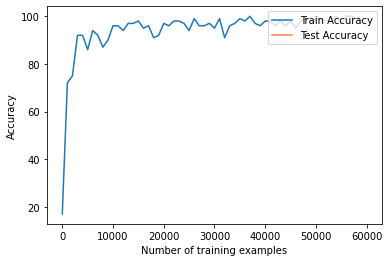

Train Epoch: 2/5 [0/60000 (0%)] Loss: 0.0235 Accuracy: 99.0000
Train Epoch: 2/5 [1000/60000 (2%)] Loss: 0.0408 Accuracy: 99.0000
Train Epoch: 2/5 [2000/60000 (3%)] Loss: 0.0153 Accuracy: 99.0000
Train Epoch: 2/5 [3000/60000 (5%)] Loss: 0.0062 Accuracy: 100.0000
Train Epoch: 2/5 [4000/60000 (7%)] Loss: 0.0171 Accuracy: 100.0000
Train Epoch: 2/5 [5000/60000 (8%)] Loss: 0.0504 Accuracy: 99.0000
Train Epoch: 2/5 [6000/60000 (10%)] Loss: 0.0326 Accuracy: 99.0000
Train Epoch: 2/5 [7000/60000 (12%)] Loss: 0.0669 Accuracy: 98.0000
Train Epoch: 2/5 [8000/60000 (13%)] Loss: 0.0558 Accuracy: 96.0000
Train Epoch: 2/5 [9000/60000 (15%)] Loss: 0.0731 Accuracy: 98.0000
Train Epoch: 2/5 [10000/60000 (17%)] Loss: 0.1186 Accuracy: 97.0000
Train Epoch: 2/5 [11000/60000 (18%)] Loss: 0.2187 Accuracy: 95.0000
Train Epoch: 2/5 [12000/60000 (20%)] Loss: 0.0151 Accuracy: 100.0000
Train Epoch: 2/5 [13000/60000 (22%)] Loss: 0.0034 Accuracy: 100.0000
Train Epoch: 2/5 [14000/60000 (23%)] Loss: 0.0086 Accuracy: 100

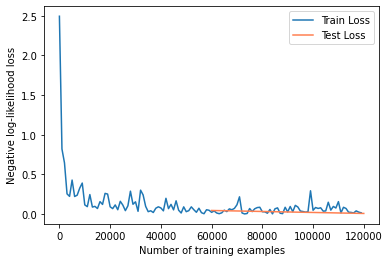

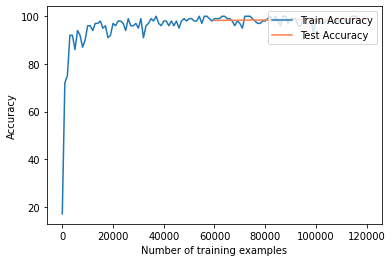

Train Epoch: 3/5 [0/60000 (0%)] Loss: 0.0043 Accuracy: 100.0000
Train Epoch: 3/5 [1000/60000 (2%)] Loss: 0.0605 Accuracy: 99.0000
Train Epoch: 3/5 [2000/60000 (3%)] Loss: 0.0125 Accuracy: 100.0000
Train Epoch: 3/5 [3000/60000 (5%)] Loss: 0.0658 Accuracy: 99.0000
Train Epoch: 3/5 [4000/60000 (7%)] Loss: 0.0079 Accuracy: 100.0000
Train Epoch: 3/5 [5000/60000 (8%)] Loss: 0.0100 Accuracy: 100.0000
Train Epoch: 3/5 [6000/60000 (10%)] Loss: 0.0162 Accuracy: 99.0000
Train Epoch: 3/5 [7000/60000 (12%)] Loss: 0.0814 Accuracy: 99.0000
Train Epoch: 3/5 [8000/60000 (13%)] Loss: 0.0398 Accuracy: 98.0000
Train Epoch: 3/5 [9000/60000 (15%)] Loss: 0.0074 Accuracy: 100.0000
Train Epoch: 3/5 [10000/60000 (17%)] Loss: 0.0069 Accuracy: 100.0000
Train Epoch: 3/5 [11000/60000 (18%)] Loss: 0.1090 Accuracy: 96.0000
Train Epoch: 3/5 [12000/60000 (20%)] Loss: 0.0053 Accuracy: 100.0000
Train Epoch: 3/5 [13000/60000 (22%)] Loss: 0.0140 Accuracy: 100.0000
Train Epoch: 3/5 [14000/60000 (23%)] Loss: 0.0168 Accuracy:

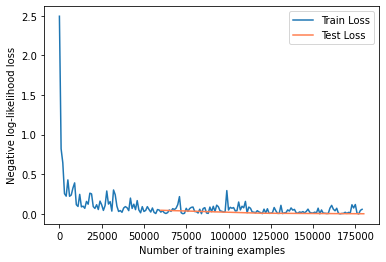

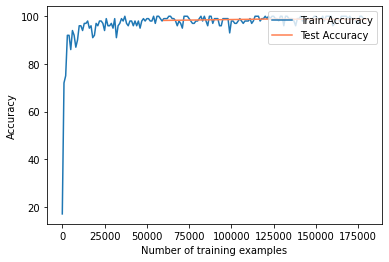

Train Epoch: 4/5 [0/60000 (0%)] Loss: 0.0032 Accuracy: 100.0000
Train Epoch: 4/5 [1000/60000 (2%)] Loss: 0.0404 Accuracy: 98.0000
Train Epoch: 4/5 [2000/60000 (3%)] Loss: 0.0149 Accuracy: 100.0000
Train Epoch: 4/5 [3000/60000 (5%)] Loss: 0.0015 Accuracy: 100.0000
Train Epoch: 4/5 [4000/60000 (7%)] Loss: 0.0062 Accuracy: 100.0000
Train Epoch: 4/5 [5000/60000 (8%)] Loss: 0.0051 Accuracy: 100.0000
Train Epoch: 4/5 [6000/60000 (10%)] Loss: 0.0824 Accuracy: 99.0000
Train Epoch: 4/5 [7000/60000 (12%)] Loss: 0.0121 Accuracy: 100.0000
Train Epoch: 4/5 [8000/60000 (13%)] Loss: 0.0474 Accuracy: 99.0000
Train Epoch: 4/5 [9000/60000 (15%)] Loss: 0.0160 Accuracy: 99.0000
Train Epoch: 4/5 [10000/60000 (17%)] Loss: 0.0261 Accuracy: 99.0000
Train Epoch: 4/5 [11000/60000 (18%)] Loss: 0.0010 Accuracy: 100.0000
Train Epoch: 4/5 [12000/60000 (20%)] Loss: 0.0036 Accuracy: 100.0000
Train Epoch: 4/5 [13000/60000 (22%)] Loss: 0.0637 Accuracy: 98.0000
Train Epoch: 4/5 [14000/60000 (23%)] Loss: 0.0183 Accuracy:

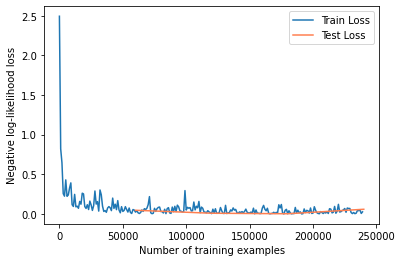

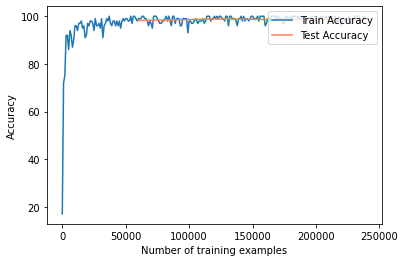

Train Epoch: 5/5 [0/60000 (0%)] Loss: 0.0161 Accuracy: 99.0000
Train Epoch: 5/5 [1000/60000 (2%)] Loss: 0.0029 Accuracy: 100.0000
Train Epoch: 5/5 [2000/60000 (3%)] Loss: 0.0080 Accuracy: 100.0000
Train Epoch: 5/5 [3000/60000 (5%)] Loss: 0.0798 Accuracy: 98.0000
Train Epoch: 5/5 [4000/60000 (7%)] Loss: 0.0322 Accuracy: 98.0000
Train Epoch: 5/5 [5000/60000 (8%)] Loss: 0.0065 Accuracy: 100.0000
Train Epoch: 5/5 [6000/60000 (10%)] Loss: 0.0478 Accuracy: 99.0000
Train Epoch: 5/5 [7000/60000 (12%)] Loss: 0.0957 Accuracy: 99.0000
Train Epoch: 5/5 [8000/60000 (13%)] Loss: 0.0959 Accuracy: 98.0000
Train Epoch: 5/5 [9000/60000 (15%)] Loss: 0.0616 Accuracy: 98.0000
Train Epoch: 5/5 [10000/60000 (17%)] Loss: 0.1016 Accuracy: 98.0000
Train Epoch: 5/5 [11000/60000 (18%)] Loss: 0.1635 Accuracy: 98.0000
Train Epoch: 5/5 [12000/60000 (20%)] Loss: 0.0042 Accuracy: 100.0000
Train Epoch: 5/5 [13000/60000 (22%)] Loss: 0.0537 Accuracy: 98.0000
Train Epoch: 5/5 [14000/60000 (23%)] Loss: 0.0155 Accuracy: 99.

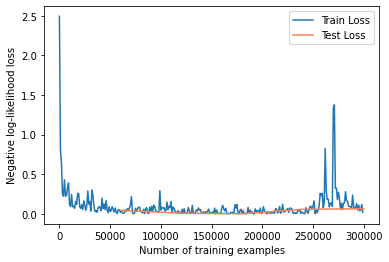

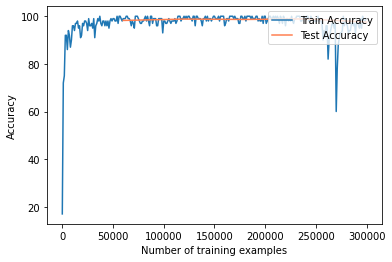

Total Time Takes 294.596599817276.


In [ ]:
ResNet50 = ResNet(config="resnet50", in_channels=1, num_classes=10).cuda()
fit(
   model=ResNet50 ,
   name="VGG11_MNIST_NEW",
   train_loader=train_mnist,
   test_loader=test_mnist,
   epoches=5,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=False
)

# VGG11_CIFAR


Train Epoch: 1/20 [0/50000 (0%)] Loss: 2.3077 Accuracy: 10.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 2.2376 Accuracy: 15.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 2.1777 Accuracy: 9.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 1.8513 Accuracy: 29.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 1.9112 Accuracy: 24.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 1.9057 Accuracy: 28.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 1.7367 Accuracy: 32.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 1.7476 Accuracy: 26.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 1.9026 Accuracy: 20.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 1.7475 Accuracy: 29.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 1.6170 Accuracy: 37.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 1.7028 Accuracy: 26.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 1.6417 Accuracy: 36.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 1.5834 Accuracy: 39.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 1.7007 Ac

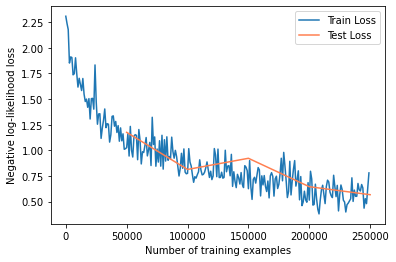

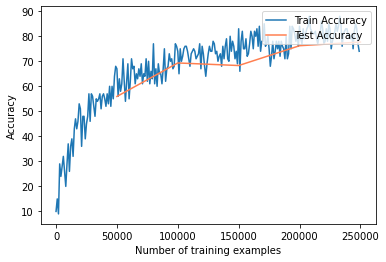

Train Epoch: 6/20 [0/50000 (0%)] Loss: 0.4258 Accuracy: 85.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 0.7165 Accuracy: 78.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 0.4490 Accuracy: 84.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 0.5827 Accuracy: 78.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 0.6227 Accuracy: 80.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 0.4415 Accuracy: 83.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 0.4331 Accuracy: 88.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 0.4998 Accuracy: 84.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 0.4827 Accuracy: 83.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 0.3979 Accuracy: 88.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 0.4927 Accuracy: 84.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 0.4542 Accuracy: 85.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 0.3936 Accuracy: 86.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 0.7085 Accuracy: 78.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 0.4968 A

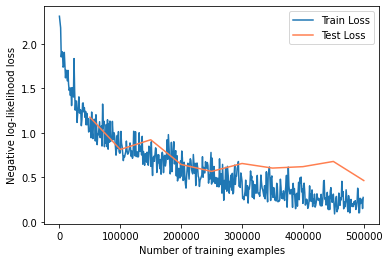

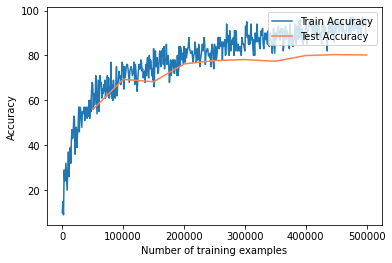

Train Epoch: 11/20 [0/50000 (0%)] Loss: 0.1265 Accuracy: 96.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 0.1450 Accuracy: 96.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 0.1113 Accuracy: 95.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 0.1505 Accuracy: 96.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 0.1266 Accuracy: 94.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 0.2188 Accuracy: 94.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 0.1878 Accuracy: 93.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 0.1406 Accuracy: 97.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 0.1111 Accuracy: 97.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 0.2894 Accuracy: 90.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 0.3246 Accuracy: 90.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 0.1532 Accuracy: 94.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 0.1691 Accuracy: 95.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 0.2670 Accuracy: 89.0000
Train Epoch: 11/20 [14000/50000 (28%)]

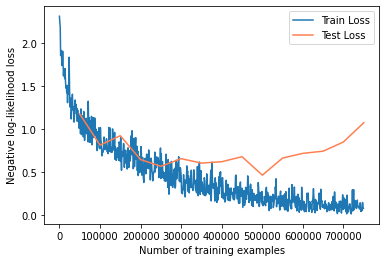

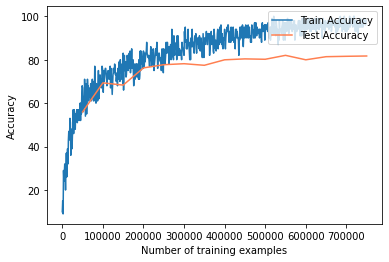

Train Epoch: 16/20 [0/50000 (0%)] Loss: 0.0200 Accuracy: 100.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 0.1398 Accuracy: 95.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 0.1020 Accuracy: 97.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 0.1116 Accuracy: 97.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 0.0795 Accuracy: 97.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 0.0823 Accuracy: 97.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 0.1067 Accuracy: 96.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 0.0095 Accuracy: 100.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 0.1406 Accuracy: 97.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 0.0144 Accuracy: 99.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 0.0244 Accuracy: 100.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 0.0176 Accuracy: 99.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 0.1219 Accuracy: 97.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 0.0220 Accuracy: 100.0000
Train Epoch: 16/20 [14000/50000 (2

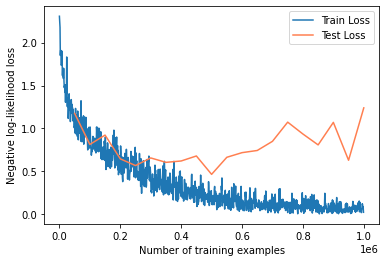

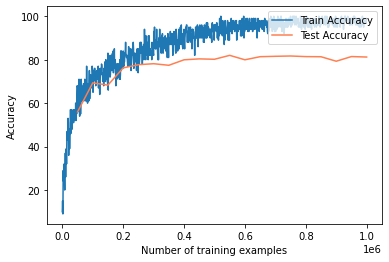

Total Time Takes 196.2753930091858.


In [ ]:
VGG11= VGG(config="VGG11").cuda()
fit(
   model=VGG11,
   name="VGG11_MNIST_NEW",
   train_loader=train_cifar10,
   test_loader=test_cifar10,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

# VGG13_CIFAR

Train Epoch: 1/20 [0/50000 (0%)] Loss: 2.3305 Accuracy: 10.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 2.2852 Accuracy: 12.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 2.2776 Accuracy: 15.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 2.2327 Accuracy: 14.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 2.2266 Accuracy: 19.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 2.0861 Accuracy: 19.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 2.1494 Accuracy: 19.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 1.9769 Accuracy: 18.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 1.9857 Accuracy: 21.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 2.0693 Accuracy: 18.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 1.9984 Accuracy: 21.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 1.9764 Accuracy: 18.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 2.0289 Accuracy: 20.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 2.0901 Accuracy: 16.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 1.9011 A

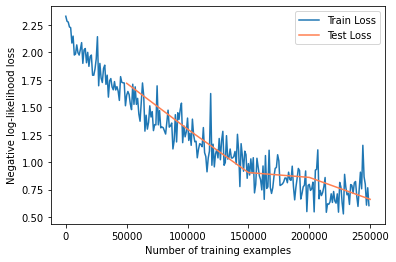

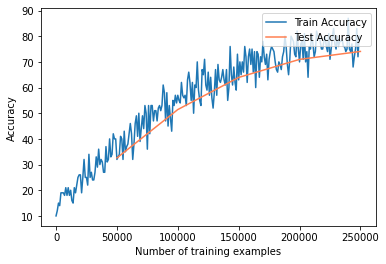

Train Epoch: 6/20 [0/50000 (0%)] Loss: 0.4755 Accuracy: 87.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 0.6949 Accuracy: 77.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 0.9104 Accuracy: 75.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 0.6732 Accuracy: 79.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 0.6308 Accuracy: 77.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 0.6526 Accuracy: 78.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 0.7828 Accuracy: 76.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 0.3729 Accuracy: 88.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 0.9747 Accuracy: 63.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 0.7330 Accuracy: 80.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 0.7630 Accuracy: 75.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 0.6449 Accuracy: 78.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 0.7177 Accuracy: 73.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 0.6236 Accuracy: 82.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 0.3968 A

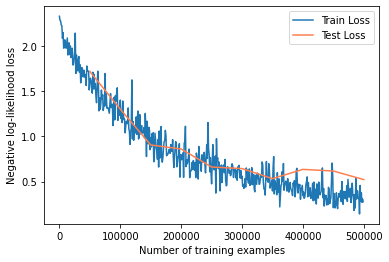

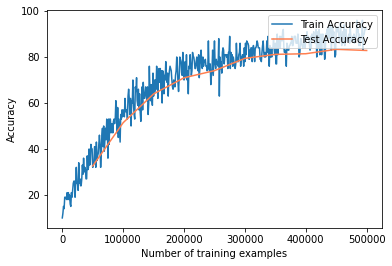

Train Epoch: 11/20 [0/50000 (0%)] Loss: 0.2628 Accuracy: 91.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 0.3046 Accuracy: 92.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 0.2064 Accuracy: 94.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 0.1133 Accuracy: 98.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 0.2022 Accuracy: 92.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 0.1805 Accuracy: 94.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 0.3473 Accuracy: 88.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 0.3800 Accuracy: 89.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 0.2911 Accuracy: 90.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 0.4081 Accuracy: 86.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 0.2127 Accuracy: 94.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 0.3071 Accuracy: 89.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 0.2120 Accuracy: 90.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 0.2868 Accuracy: 86.0000
Train Epoch: 11/20 [14000/50000 (28%)]

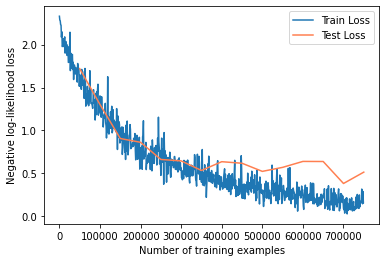

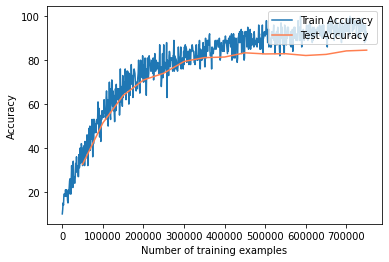

Train Epoch: 16/20 [0/50000 (0%)] Loss: 0.1030 Accuracy: 95.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 0.1010 Accuracy: 98.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 0.1615 Accuracy: 96.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 0.3396 Accuracy: 96.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 0.2834 Accuracy: 91.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 0.1137 Accuracy: 95.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 0.0835 Accuracy: 96.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 0.2206 Accuracy: 96.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 0.2221 Accuracy: 94.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 0.1664 Accuracy: 95.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 0.1722 Accuracy: 94.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 0.0977 Accuracy: 96.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 0.2606 Accuracy: 88.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 0.0883 Accuracy: 97.0000
Train Epoch: 16/20 [14000/50000 (28%)]

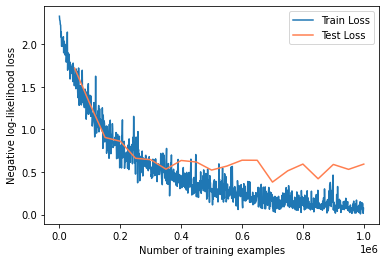

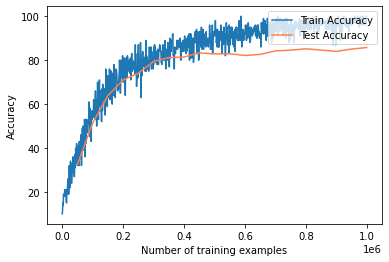

Total Time Takes 342.7889518737793.


In [ ]:
VGG13=VGG(config="VGG13").cuda()
fit(
   model=VGG13,
   name="VGG11_MNIST_NEW",
   train_loader=train_cifar10,
   test_loader=test_cifar10,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

# VGG16_CIFAR

Train Epoch: 1/20 [0/50000 (0%)] Loss: 2.3606 Accuracy: 9.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 2.3272 Accuracy: 9.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 2.2647 Accuracy: 9.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 2.2242 Accuracy: 17.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 2.2795 Accuracy: 13.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 2.2572 Accuracy: 10.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 2.2148 Accuracy: 12.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 2.2031 Accuracy: 14.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 2.1078 Accuracy: 14.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 2.1207 Accuracy: 16.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 2.0396 Accuracy: 21.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 2.0013 Accuracy: 28.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 2.0261 Accuracy: 12.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 1.9997 Accuracy: 19.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 1.9596 Accu

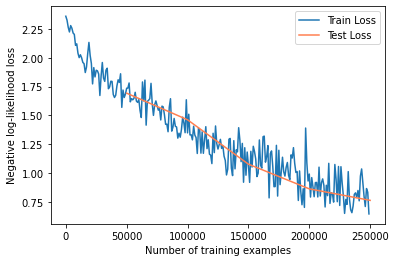

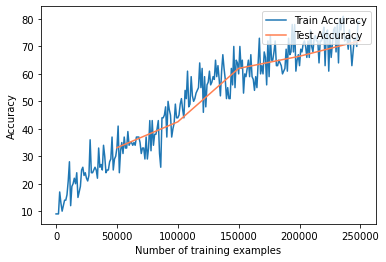

Train Epoch: 6/20 [0/50000 (0%)] Loss: 1.0309 Accuracy: 64.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 0.8953 Accuracy: 75.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 0.8260 Accuracy: 76.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 0.8369 Accuracy: 67.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 0.8403 Accuracy: 74.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 1.0068 Accuracy: 68.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 0.7920 Accuracy: 74.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 0.7655 Accuracy: 72.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 0.6992 Accuracy: 74.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 0.7340 Accuracy: 76.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 0.6330 Accuracy: 82.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 0.7249 Accuracy: 81.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 0.7978 Accuracy: 76.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 0.7312 Accuracy: 73.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 0.9415 A

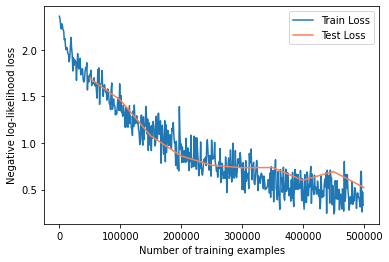

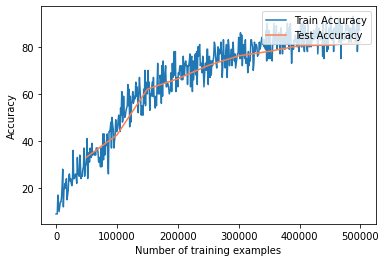

Train Epoch: 11/20 [0/50000 (0%)] Loss: 0.4222 Accuracy: 85.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 0.3714 Accuracy: 87.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 0.3978 Accuracy: 86.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 0.3820 Accuracy: 87.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 0.3766 Accuracy: 89.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 0.5492 Accuracy: 86.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 0.3312 Accuracy: 88.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 0.4647 Accuracy: 84.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 0.4884 Accuracy: 88.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 0.2629 Accuracy: 92.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 0.3898 Accuracy: 87.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 0.2369 Accuracy: 92.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 0.2677 Accuracy: 91.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 0.4948 Accuracy: 84.0000
Train Epoch: 11/20 [14000/50000 (28%)]

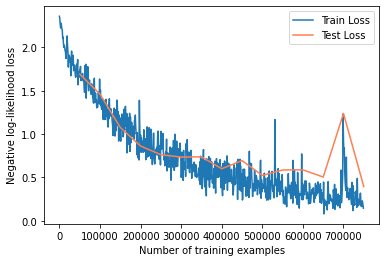

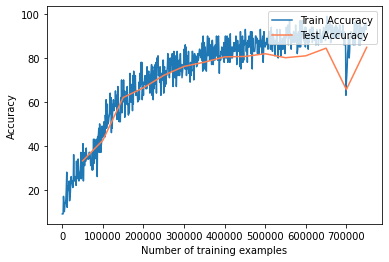

Train Epoch: 16/20 [0/50000 (0%)] Loss: 0.1987 Accuracy: 96.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 0.2393 Accuracy: 91.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 0.1220 Accuracy: 96.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 0.1334 Accuracy: 97.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 0.2495 Accuracy: 94.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 0.2470 Accuracy: 93.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 0.1286 Accuracy: 95.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 0.2305 Accuracy: 92.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 0.1913 Accuracy: 95.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 0.1825 Accuracy: 95.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 0.1131 Accuracy: 97.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 0.2741 Accuracy: 92.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 0.1956 Accuracy: 94.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 0.1854 Accuracy: 93.0000
Train Epoch: 16/20 [14000/50000 (28%)]

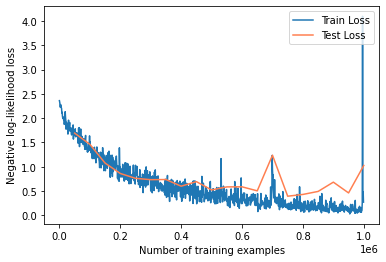

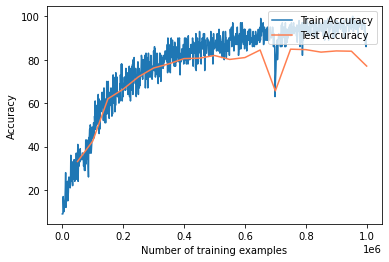

Total Time Takes 423.99864864349365.


In [ ]:
VGG16=VGG(config="VGG16").cuda()
fit(
   model=VGG16,
   name="VGG11_MNIST_NEW",
   train_loader=train_cifar10,
   test_loader=test_cifar10,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

# VGG19_CIFAR

Train Epoch: 1/20 [0/50000 (0%)] Loss: 2.3350 Accuracy: 7.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 2.2787 Accuracy: 19.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 2.2519 Accuracy: 13.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 2.2168 Accuracy: 14.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 2.3269 Accuracy: 12.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 2.1865 Accuracy: 18.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 2.0324 Accuracy: 23.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 2.0864 Accuracy: 15.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 1.9615 Accuracy: 19.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 2.0177 Accuracy: 17.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 1.9403 Accuracy: 24.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 2.0396 Accuracy: 18.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 1.8707 Accuracy: 19.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 1.9498 Accuracy: 16.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 2.0988 Ac

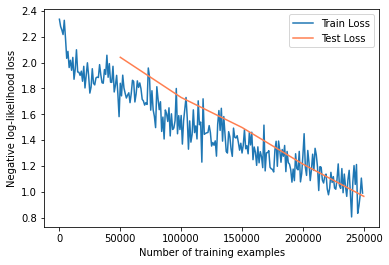

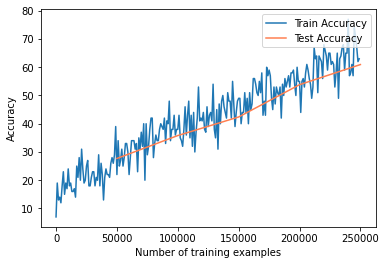

Train Epoch: 6/20 [0/50000 (0%)] Loss: 1.1165 Accuracy: 60.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 1.0865 Accuracy: 64.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 1.0547 Accuracy: 59.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 1.1760 Accuracy: 62.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 1.1741 Accuracy: 62.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 1.0207 Accuracy: 65.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 0.8576 Accuracy: 75.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 0.9022 Accuracy: 67.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 1.0122 Accuracy: 63.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 1.0425 Accuracy: 61.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 0.8447 Accuracy: 71.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 1.0449 Accuracy: 61.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 1.1336 Accuracy: 63.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 1.0501 Accuracy: 61.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 0.9235 A

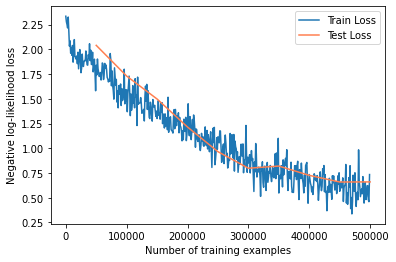

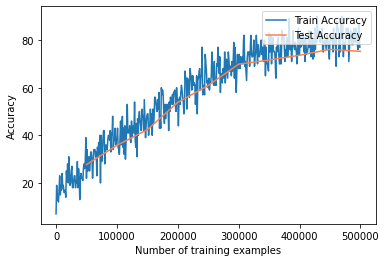

Train Epoch: 11/20 [0/50000 (0%)] Loss: 0.5215 Accuracy: 85.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 0.3626 Accuracy: 88.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 0.5853 Accuracy: 76.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 0.5154 Accuracy: 81.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 0.5310 Accuracy: 84.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 0.5673 Accuracy: 78.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 0.5365 Accuracy: 82.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 0.7275 Accuracy: 87.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 0.7716 Accuracy: 79.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 0.5453 Accuracy: 83.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 0.6500 Accuracy: 73.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 0.4266 Accuracy: 86.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 0.5114 Accuracy: 85.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 0.6504 Accuracy: 79.0000
Train Epoch: 11/20 [14000/50000 (28%)]

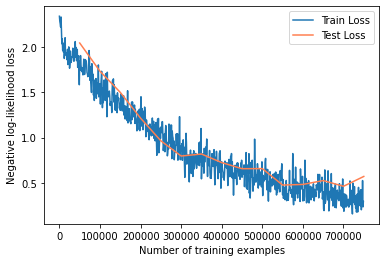

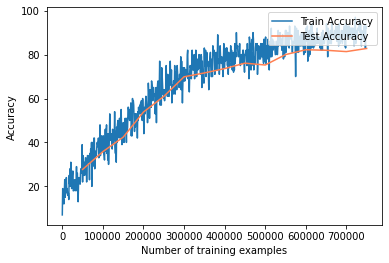

Train Epoch: 16/20 [0/50000 (0%)] Loss: 0.4042 Accuracy: 90.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 0.1884 Accuracy: 94.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 0.2674 Accuracy: 89.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 0.2589 Accuracy: 93.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 0.3375 Accuracy: 91.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 0.2153 Accuracy: 94.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 0.4067 Accuracy: 88.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 0.4133 Accuracy: 88.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 0.2223 Accuracy: 93.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 0.2202 Accuracy: 92.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 0.4381 Accuracy: 92.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 0.3073 Accuracy: 91.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 0.1223 Accuracy: 96.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 0.3053 Accuracy: 88.0000
Train Epoch: 16/20 [14000/50000 (28%)]

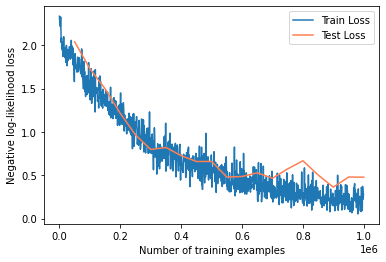

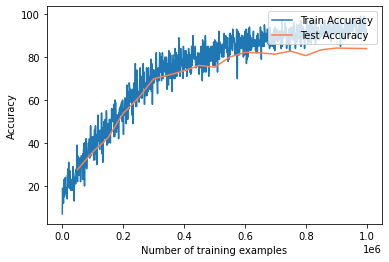

Total Time Takes 507.3351836204529.


In [ ]:
VGG19=VGG(config="VGG19").cuda()
fit(
   model=VGG19,
   name="VGG11_MNIST_NEW",
   train_loader=train_cifar10,
   test_loader=test_cifar10,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

# ResNet18_CIFAR


Train Epoch: 1/20 [0/50000 (0%)] Loss: 2.4721 Accuracy: 8.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 1.8451 Accuracy: 37.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 1.8408 Accuracy: 27.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 1.5099 Accuracy: 44.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 1.6334 Accuracy: 34.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 1.4937 Accuracy: 48.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 1.4356 Accuracy: 48.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 1.5697 Accuracy: 43.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 1.2883 Accuracy: 57.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 1.4720 Accuracy: 44.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 1.4165 Accuracy: 51.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 1.4945 Accuracy: 50.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 1.4362 Accuracy: 39.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 1.1938 Accuracy: 55.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 1.4394 Ac

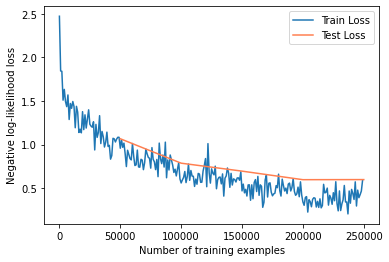

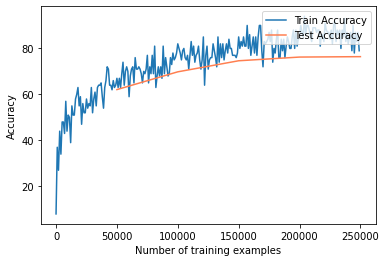

Train Epoch: 6/20 [0/50000 (0%)] Loss: 0.3381 Accuracy: 88.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 0.3036 Accuracy: 93.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 0.3350 Accuracy: 89.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 0.2296 Accuracy: 93.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 0.1856 Accuracy: 97.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 0.2705 Accuracy: 90.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 0.2096 Accuracy: 95.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 0.2059 Accuracy: 89.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 0.1499 Accuracy: 96.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 0.2103 Accuracy: 92.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 0.1844 Accuracy: 95.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 0.3972 Accuracy: 84.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 0.3524 Accuracy: 85.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 0.3696 Accuracy: 88.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 0.4056 A

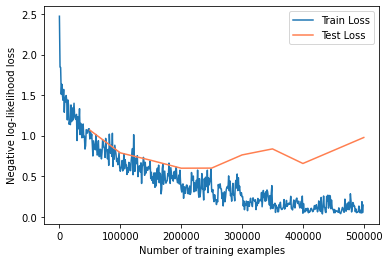

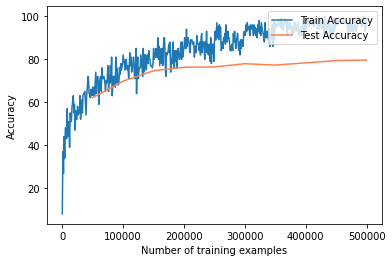

Train Epoch: 11/20 [0/50000 (0%)] Loss: 0.1062 Accuracy: 97.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 0.0477 Accuracy: 98.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 0.0291 Accuracy: 100.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 0.0762 Accuracy: 98.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 0.0985 Accuracy: 96.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 0.0803 Accuracy: 98.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 0.0186 Accuracy: 99.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 0.0924 Accuracy: 97.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 0.0314 Accuracy: 100.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 0.0129 Accuracy: 100.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 0.0590 Accuracy: 97.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 0.0258 Accuracy: 99.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 0.0944 Accuracy: 98.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 0.0570 Accuracy: 98.0000
Train Epoch: 11/20 [14000/50000 (28

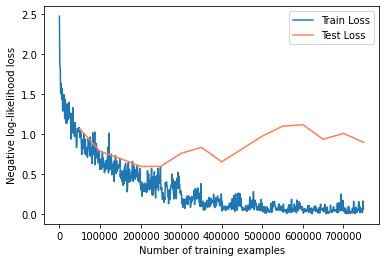

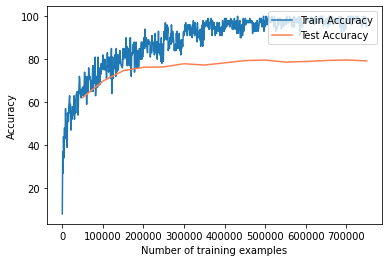

Train Epoch: 16/20 [0/50000 (0%)] Loss: 0.0338 Accuracy: 98.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 0.0237 Accuracy: 99.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 0.0529 Accuracy: 98.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 0.0797 Accuracy: 96.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 0.0114 Accuracy: 99.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 0.0378 Accuracy: 98.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 0.0684 Accuracy: 97.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 0.0218 Accuracy: 99.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 0.0400 Accuracy: 99.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 0.0341 Accuracy: 99.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 0.1099 Accuracy: 96.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 0.0137 Accuracy: 100.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 0.0294 Accuracy: 99.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 0.0642 Accuracy: 99.0000
Train Epoch: 16/20 [14000/50000 (28%)

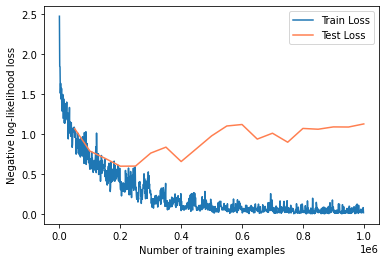

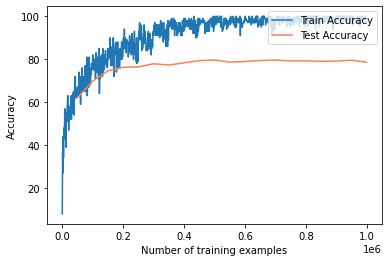

Total Time Takes 349.32685589790344.


In [ ]:
ResNet18 = ResNet(in_channels=3, num_classes=10, config="resnet18").cuda()
fit(
   model=ResNet18,
   name="ResNet34_CIFAR100",
   train_loader=train_cifar10,
   test_loader=test_cifar10,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

# ResNet34_CIFAR


Train Epoch: 1/20 [0/50000 (0%)] Loss: 2.5976 Accuracy: 6.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 1.9735 Accuracy: 20.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 1.7894 Accuracy: 31.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 1.6989 Accuracy: 40.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 1.6872 Accuracy: 34.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 1.6142 Accuracy: 38.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 1.6083 Accuracy: 41.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 1.5589 Accuracy: 46.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 1.6730 Accuracy: 43.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 1.5121 Accuracy: 43.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 1.6397 Accuracy: 44.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 1.5339 Accuracy: 45.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 1.5313 Accuracy: 51.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 1.2137 Accuracy: 54.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 1.5410 Ac

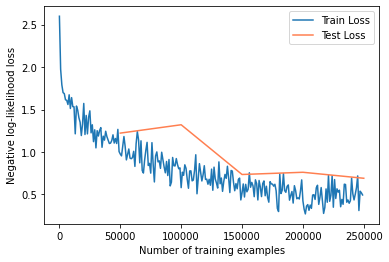

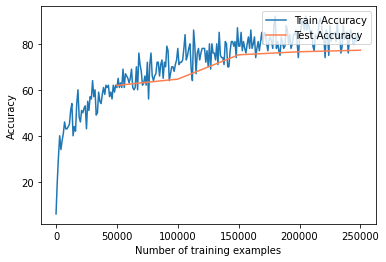

Train Epoch: 6/20 [0/50000 (0%)] Loss: 0.4821 Accuracy: 82.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 0.3263 Accuracy: 92.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 0.2602 Accuracy: 90.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 0.2454 Accuracy: 92.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 0.3992 Accuracy: 89.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 0.5144 Accuracy: 83.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 0.4007 Accuracy: 85.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 0.2887 Accuracy: 91.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 0.4195 Accuracy: 86.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 0.3217 Accuracy: 87.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 0.4795 Accuracy: 86.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 0.3061 Accuracy: 88.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 0.3269 Accuracy: 86.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 0.4226 Accuracy: 90.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 0.3926 A

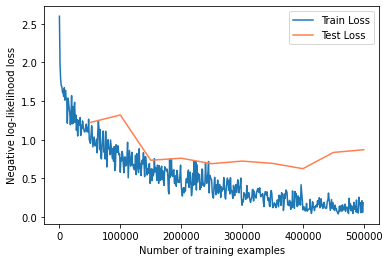

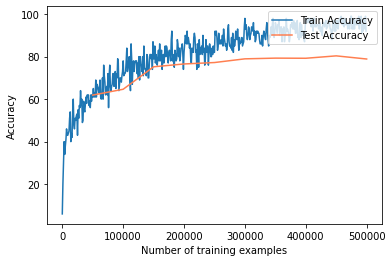

Train Epoch: 11/20 [0/50000 (0%)] Loss: 0.0869 Accuracy: 97.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 0.0940 Accuracy: 97.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 0.0588 Accuracy: 98.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 0.0419 Accuracy: 100.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 0.0898 Accuracy: 96.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 0.0832 Accuracy: 98.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 0.0107 Accuracy: 100.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 0.0455 Accuracy: 99.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 0.0177 Accuracy: 100.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 0.0560 Accuracy: 98.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 0.1134 Accuracy: 98.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 0.0434 Accuracy: 98.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 0.0519 Accuracy: 98.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 0.0371 Accuracy: 100.0000
Train Epoch: 11/20 [14000/50000 (2

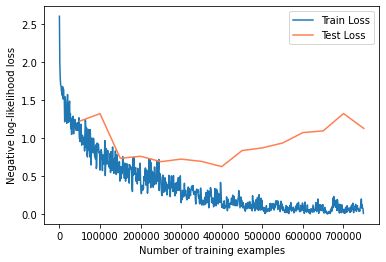

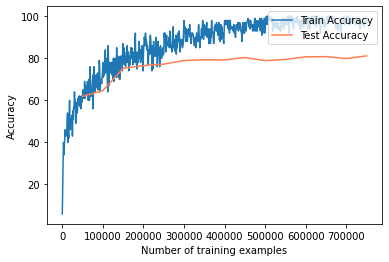

Train Epoch: 16/20 [0/50000 (0%)] Loss: 0.0275 Accuracy: 99.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 0.0614 Accuracy: 97.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 0.0362 Accuracy: 99.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 0.0510 Accuracy: 98.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 0.1789 Accuracy: 95.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 0.0506 Accuracy: 98.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 0.0245 Accuracy: 99.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 0.0804 Accuracy: 96.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 0.0554 Accuracy: 99.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 0.0557 Accuracy: 98.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 0.0455 Accuracy: 98.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 0.0441 Accuracy: 99.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 0.0138 Accuracy: 100.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 0.0656 Accuracy: 99.0000
Train Epoch: 16/20 [14000/50000 (28%)

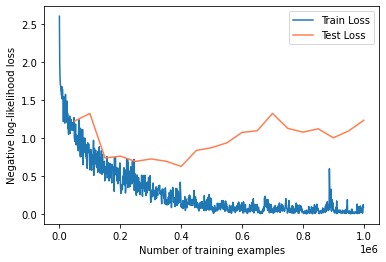

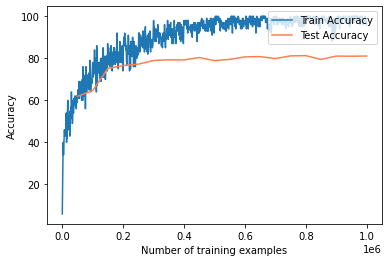

Total Time Takes 543.5650062561035.


In [ ]:
ResNet34 = ResNet(in_channels=3, num_classes=10, config="resnet34").cuda()
fit(
   model=ResNet34,
   name="ResNet34_CIFAR100",
   train_loader=train_cifar10,
   test_loader=test_cifar10,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

# ResNet50_CIFAR


Train Epoch: 1/20 [0/50000 (0%)] Loss: 2.5063 Accuracy: 13.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 2.3050 Accuracy: 18.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 2.0823 Accuracy: 20.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 2.0939 Accuracy: 40.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 1.7364 Accuracy: 34.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 2.2469 Accuracy: 27.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 1.5533 Accuracy: 45.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 2.0996 Accuracy: 25.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 1.6237 Accuracy: 42.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 1.6760 Accuracy: 45.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 1.6769 Accuracy: 46.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 1.7275 Accuracy: 39.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 1.6813 Accuracy: 43.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 1.6742 Accuracy: 36.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 1.7971 A

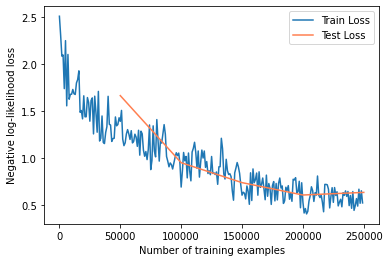

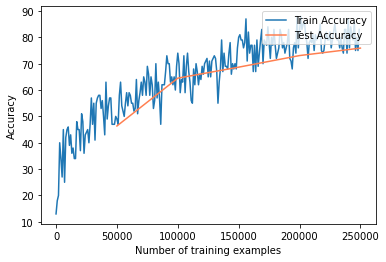

Train Epoch: 6/20 [0/50000 (0%)] Loss: 0.3571 Accuracy: 87.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 0.2581 Accuracy: 93.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 0.4542 Accuracy: 85.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 0.6476 Accuracy: 81.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 0.4648 Accuracy: 86.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 0.4832 Accuracy: 84.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 0.3238 Accuracy: 88.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 0.4959 Accuracy: 77.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 0.4337 Accuracy: 88.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 0.4346 Accuracy: 81.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 0.3906 Accuracy: 84.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 0.4027 Accuracy: 89.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 0.4381 Accuracy: 83.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 0.3462 Accuracy: 88.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 0.3877 A

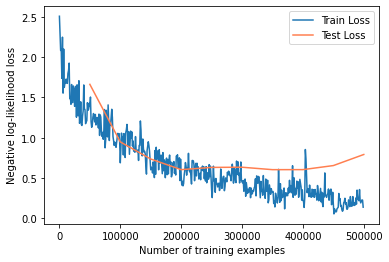

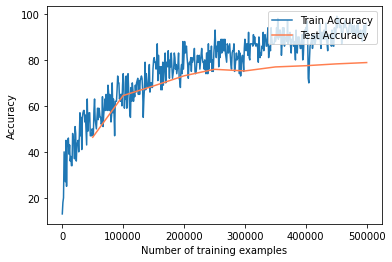

Train Epoch: 11/20 [0/50000 (0%)] Loss: 0.2192 Accuracy: 92.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 0.1554 Accuracy: 97.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 0.1067 Accuracy: 96.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 0.1753 Accuracy: 96.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 0.1146 Accuracy: 97.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 0.0594 Accuracy: 96.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 0.0367 Accuracy: 99.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 0.0726 Accuracy: 98.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 0.0907 Accuracy: 97.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 0.0924 Accuracy: 97.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 0.1160 Accuracy: 98.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 0.1803 Accuracy: 93.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 0.1880 Accuracy: 92.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 0.1291 Accuracy: 95.0000
Train Epoch: 11/20 [14000/50000 (28%)]

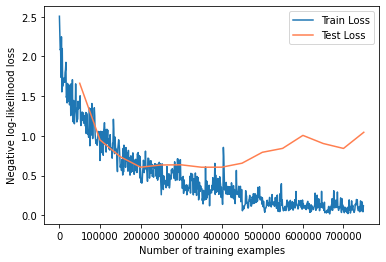

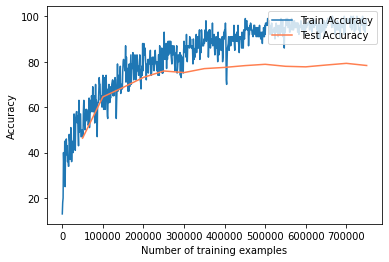

Train Epoch: 16/20 [0/50000 (0%)] Loss: 0.0915 Accuracy: 95.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 0.0525 Accuracy: 98.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 0.1577 Accuracy: 95.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 0.0727 Accuracy: 96.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 0.0279 Accuracy: 99.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 0.0723 Accuracy: 97.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 0.1060 Accuracy: 96.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 0.0433 Accuracy: 99.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 0.0704 Accuracy: 96.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 0.0538 Accuracy: 97.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 0.0261 Accuracy: 99.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 0.0791 Accuracy: 98.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 0.0317 Accuracy: 99.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 0.0482 Accuracy: 99.0000
Train Epoch: 16/20 [14000/50000 (28%)]

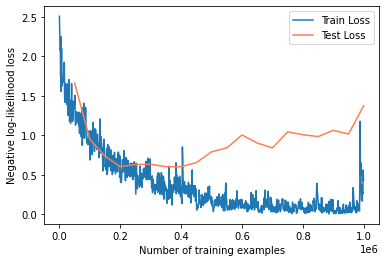

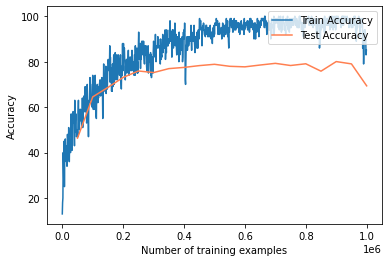

Total Time Takes 845.947669506073.


In [ ]:
ResNet50 = ResNet(in_channels=3, num_classes=10, config="resnet50").cuda()
fit(
   model=ResNet50,
   name="ResNet34_CIFAR100",
   train_loader=train_cifar10,
   test_loader=test_cifar10,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

# VGG11_CIFAR100


Train Epoch: 1/20 [0/50000 (0%)] Loss: 4.6357 Accuracy: 1.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 4.5825 Accuracy: 0.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 4.6013 Accuracy: 2.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 4.5755 Accuracy: 2.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 4.6192 Accuracy: 2.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 4.4819 Accuracy: 0.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 4.5108 Accuracy: 0.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 4.4651 Accuracy: 1.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 4.2839 Accuracy: 5.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 4.2292 Accuracy: 4.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 4.2039 Accuracy: 6.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 4.3088 Accuracy: 4.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 4.2922 Accuracy: 5.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 4.2571 Accuracy: 3.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 4.2644 Accuracy: 5.000

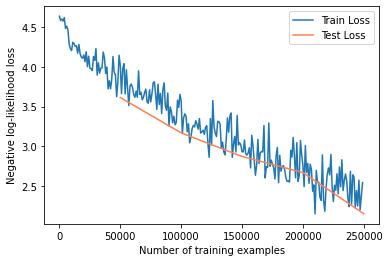

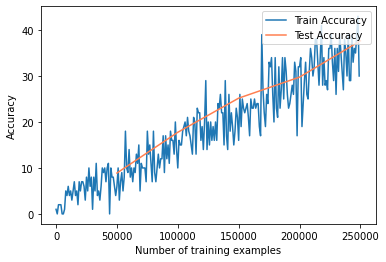

Train Epoch: 6/20 [0/50000 (0%)] Loss: 2.2406 Accuracy: 43.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 2.2024 Accuracy: 39.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 2.3998 Accuracy: 38.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 2.3346 Accuracy: 38.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 2.5031 Accuracy: 34.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 2.5051 Accuracy: 35.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 2.1420 Accuracy: 41.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 2.2694 Accuracy: 44.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 2.5465 Accuracy: 31.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 2.1091 Accuracy: 39.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 2.1755 Accuracy: 45.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 2.2619 Accuracy: 41.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 2.5212 Accuracy: 38.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 2.5871 Accuracy: 33.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 2.1579 A

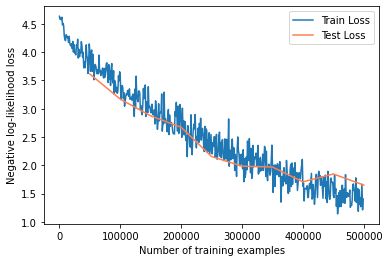

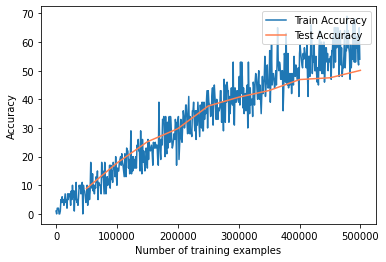

Train Epoch: 11/20 [0/50000 (0%)] Loss: 1.2718 Accuracy: 65.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 1.3019 Accuracy: 64.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 1.0351 Accuracy: 69.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 1.0733 Accuracy: 68.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 0.8398 Accuracy: 71.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 0.8456 Accuracy: 74.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 1.0818 Accuracy: 70.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 1.1514 Accuracy: 67.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 1.0606 Accuracy: 67.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 1.1167 Accuracy: 71.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 1.2048 Accuracy: 63.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 1.3001 Accuracy: 62.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 1.0413 Accuracy: 65.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 1.3408 Accuracy: 61.0000
Train Epoch: 11/20 [14000/50000 (28%)]

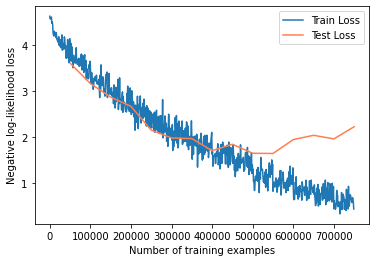

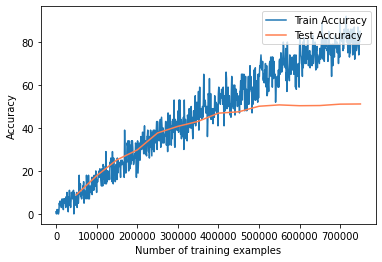

Train Epoch: 16/20 [0/50000 (0%)] Loss: 0.4057 Accuracy: 87.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 0.4561 Accuracy: 86.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 0.5140 Accuracy: 80.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 0.5252 Accuracy: 83.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 0.4731 Accuracy: 81.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 0.3577 Accuracy: 89.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 0.6721 Accuracy: 79.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 0.6736 Accuracy: 81.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 0.4403 Accuracy: 85.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 0.4351 Accuracy: 85.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 0.4552 Accuracy: 86.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 0.4735 Accuracy: 89.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 0.6020 Accuracy: 81.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 0.4837 Accuracy: 84.0000
Train Epoch: 16/20 [14000/50000 (28%)]

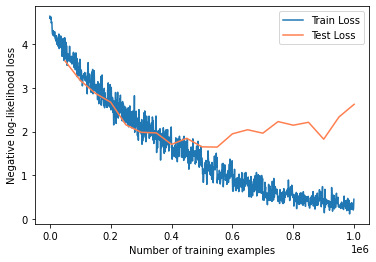

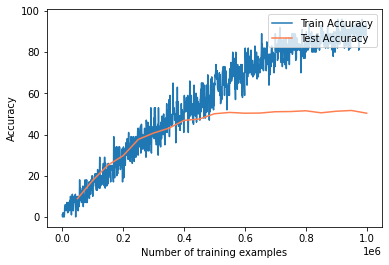

Total Time Takes 197.70177602767944.


In [ ]:
VGG11= VGG(config="VGG11").cuda()
fit(
   model=VGG11,
   name="VGG11_MNIST_NEW",
   train_loader=train_cifar100,
   test_loader=test_cifar100,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

#VGG13_CIFAR100


Train Epoch: 1/20 [0/50000 (0%)] Loss: 4.6803 Accuracy: 0.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 4.7411 Accuracy: 0.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 4.5938 Accuracy: 0.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 4.5899 Accuracy: 1.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 4.5564 Accuracy: 2.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 4.6714 Accuracy: 1.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 4.5481 Accuracy: 0.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 4.5609 Accuracy: 2.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 4.4849 Accuracy: 1.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 4.5113 Accuracy: 2.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 4.5140 Accuracy: 2.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 4.4423 Accuracy: 3.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 4.4756 Accuracy: 1.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 4.4486 Accuracy: 0.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 4.4473 Accuracy: 2.000

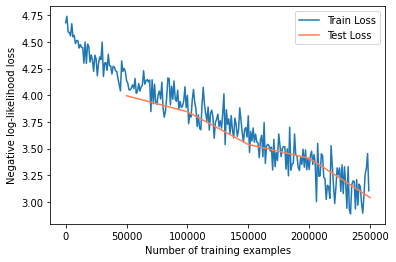

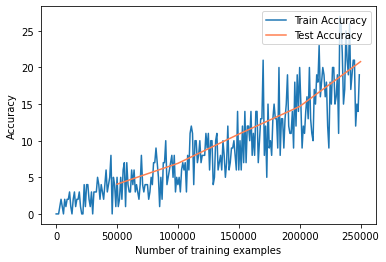

Train Epoch: 6/20 [0/50000 (0%)] Loss: 3.0227 Accuracy: 21.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 3.2065 Accuracy: 22.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 2.9056 Accuracy: 27.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 2.8800 Accuracy: 24.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 2.9048 Accuracy: 17.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 3.0083 Accuracy: 20.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 3.1801 Accuracy: 22.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 2.9956 Accuracy: 18.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 2.9526 Accuracy: 19.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 2.5920 Accuracy: 28.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 2.9046 Accuracy: 17.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 2.7591 Accuracy: 30.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 2.8588 Accuracy: 28.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 2.7193 Accuracy: 25.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 3.1002 A

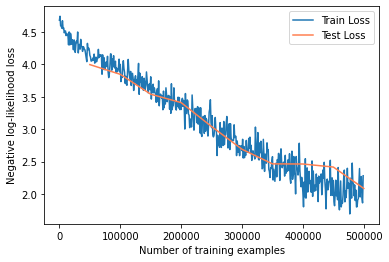

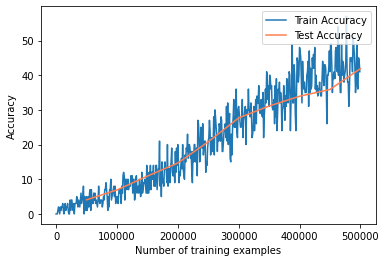

Train Epoch: 11/20 [0/50000 (0%)] Loss: 1.7776 Accuracy: 50.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 1.6496 Accuracy: 52.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 1.6969 Accuracy: 54.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 1.6366 Accuracy: 48.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 1.8338 Accuracy: 49.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 1.6880 Accuracy: 50.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 1.9149 Accuracy: 46.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 1.8366 Accuracy: 46.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 1.5433 Accuracy: 51.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 2.1530 Accuracy: 37.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 1.6165 Accuracy: 49.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 1.4788 Accuracy: 58.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 1.7100 Accuracy: 45.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 1.9576 Accuracy: 51.0000
Train Epoch: 11/20 [14000/50000 (28%)]

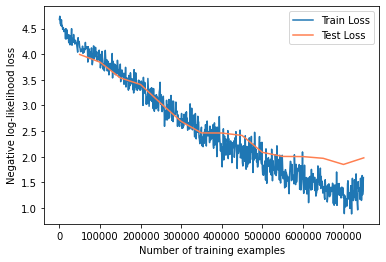

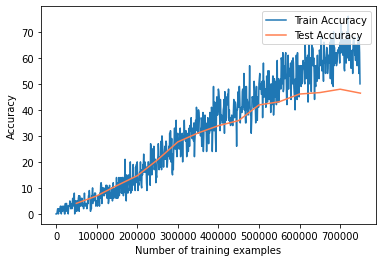

Train Epoch: 16/20 [0/50000 (0%)] Loss: 1.0502 Accuracy: 70.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 1.4407 Accuracy: 59.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 0.9672 Accuracy: 74.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 0.8267 Accuracy: 71.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 1.1313 Accuracy: 65.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 0.9756 Accuracy: 72.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 0.8250 Accuracy: 74.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 0.9646 Accuracy: 65.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 0.9785 Accuracy: 67.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 1.1870 Accuracy: 63.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 1.0668 Accuracy: 70.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 1.3512 Accuracy: 63.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 1.0787 Accuracy: 71.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 0.9595 Accuracy: 76.0000
Train Epoch: 16/20 [14000/50000 (28%)]

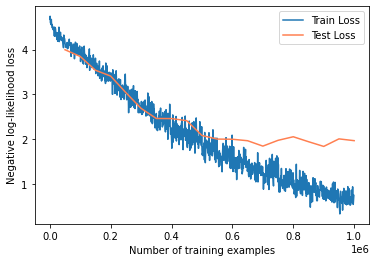

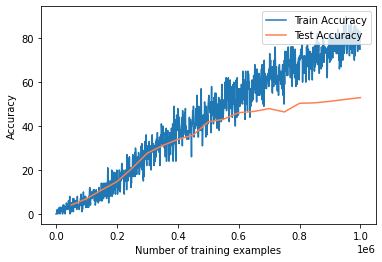

Total Time Takes 343.86050033569336.


In [ ]:
VGG13= VGG(config="VGG13").cuda()
fit(
   model=VGG13,
   name="VGG11_MNIST_NEW",
   train_loader=train_cifar100,
   test_loader=test_cifar100,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

# VGG16_CIFAR100


Train Epoch: 1/20 [0/50000 (0%)] Loss: 4.6324 Accuracy: 2.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 4.6467 Accuracy: 0.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 4.6085 Accuracy: 3.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 4.5825 Accuracy: 2.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 4.5230 Accuracy: 5.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 4.5559 Accuracy: 1.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 4.5488 Accuracy: 1.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 4.5017 Accuracy: 1.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 4.4810 Accuracy: 0.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 4.4828 Accuracy: 2.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 4.4993 Accuracy: 1.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 4.6294 Accuracy: 0.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 4.3674 Accuracy: 3.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 4.4356 Accuracy: 1.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 4.4352 Accuracy: 3.000

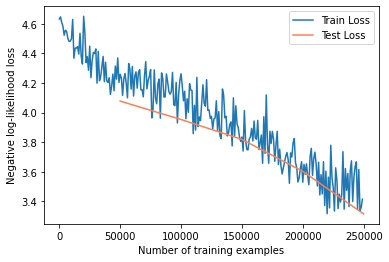

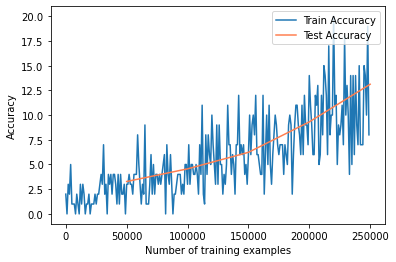

Train Epoch: 6/20 [0/50000 (0%)] Loss: 3.4556 Accuracy: 12.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 3.4147 Accuracy: 9.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 3.5243 Accuracy: 9.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 3.2772 Accuracy: 18.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 3.3115 Accuracy: 8.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 3.6488 Accuracy: 12.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 3.3782 Accuracy: 7.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 3.2805 Accuracy: 13.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 3.2932 Accuracy: 14.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 3.3058 Accuracy: 9.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 3.5160 Accuracy: 16.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 3.5727 Accuracy: 10.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 3.4530 Accuracy: 8.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 3.2089 Accuracy: 10.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 3.4234 Accurac

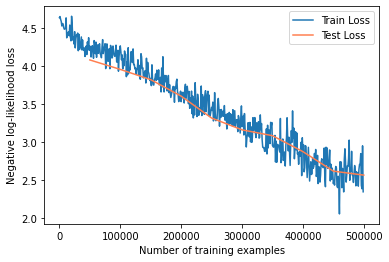

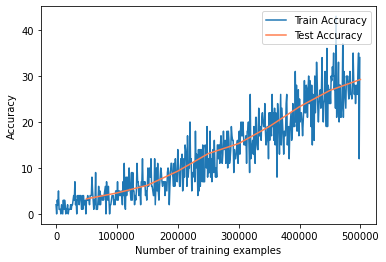

Train Epoch: 11/20 [0/50000 (0%)] Loss: 2.2563 Accuracy: 33.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 2.3967 Accuracy: 29.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 2.5799 Accuracy: 33.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 2.6043 Accuracy: 30.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 2.2930 Accuracy: 30.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 2.3486 Accuracy: 26.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 2.4116 Accuracy: 37.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 2.2956 Accuracy: 31.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 2.3296 Accuracy: 31.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 2.5425 Accuracy: 32.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 2.5901 Accuracy: 28.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 2.6798 Accuracy: 25.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 2.2599 Accuracy: 44.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 2.3028 Accuracy: 34.0000
Train Epoch: 11/20 [14000/50000 (28%)]

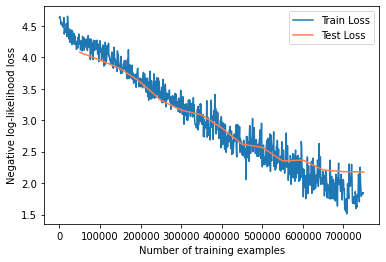

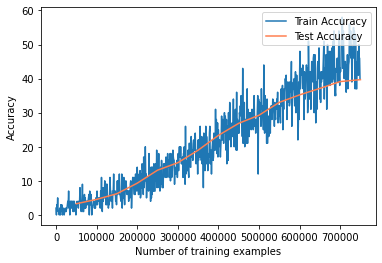

Train Epoch: 16/20 [0/50000 (0%)] Loss: 1.7483 Accuracy: 46.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 1.5017 Accuracy: 49.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 2.1354 Accuracy: 39.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 1.8745 Accuracy: 42.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 1.7468 Accuracy: 48.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 1.5563 Accuracy: 45.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 1.6404 Accuracy: 45.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 1.5806 Accuracy: 53.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 1.3690 Accuracy: 55.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 1.8087 Accuracy: 49.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 1.9245 Accuracy: 44.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 1.7626 Accuracy: 44.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 1.6057 Accuracy: 54.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 1.6409 Accuracy: 51.0000
Train Epoch: 16/20 [14000/50000 (28%)]

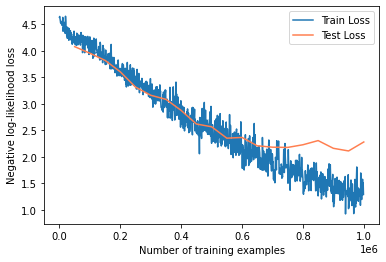

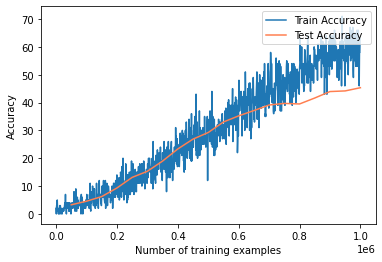

Total Time Takes 427.0277214050293.


In [ ]:
VGG16= VGG(config="VGG16").cuda()
fit(
   model=VGG16,
   name="VGG11_MNIST_NEW",
   train_loader=train_cifar100,
   test_loader=test_cifar100,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

# VGG19_CIFAR100

Train Epoch: 1/20 [0/50000 (0%)] Loss: 4.6639 Accuracy: 0.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 4.7056 Accuracy: 2.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 4.6081 Accuracy: 1.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 4.5670 Accuracy: 1.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 4.5999 Accuracy: 0.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 4.5502 Accuracy: 2.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 4.5996 Accuracy: 1.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 4.5499 Accuracy: 2.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 4.5563 Accuracy: 2.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 4.5526 Accuracy: 1.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 4.4791 Accuracy: 3.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 4.4638 Accuracy: 2.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 4.5290 Accuracy: 2.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 4.4706 Accuracy: 1.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 4.5047 Accuracy: 0.000

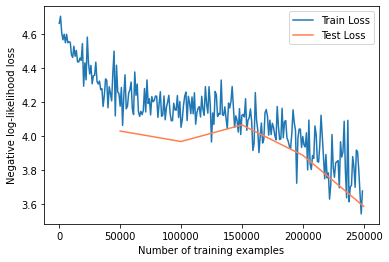

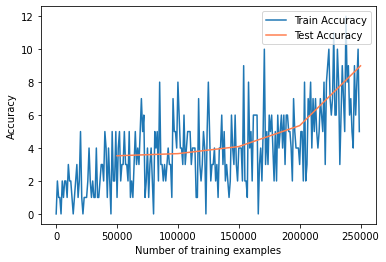

Train Epoch: 6/20 [0/50000 (0%)] Loss: 3.8712 Accuracy: 5.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 3.6254 Accuracy: 5.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 3.6701 Accuracy: 9.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 3.7577 Accuracy: 6.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 3.6502 Accuracy: 14.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 3.7144 Accuracy: 7.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 3.7978 Accuracy: 12.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 3.6958 Accuracy: 10.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 3.7775 Accuracy: 3.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 3.7103 Accuracy: 10.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 3.6396 Accuracy: 7.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 3.6085 Accuracy: 5.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 3.5277 Accuracy: 12.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 3.5729 Accuracy: 7.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 3.8001 Accuracy: 

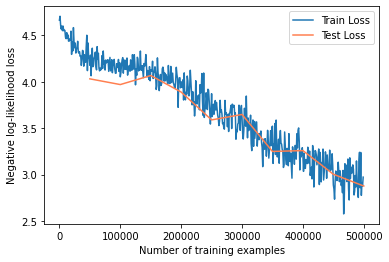

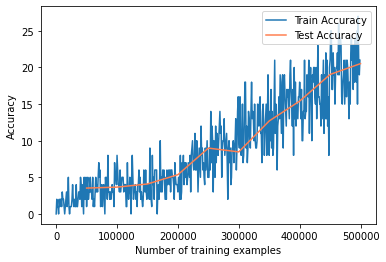

Train Epoch: 11/20 [0/50000 (0%)] Loss: 2.7290 Accuracy: 25.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 2.7300 Accuracy: 27.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 2.9253 Accuracy: 20.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 2.8986 Accuracy: 16.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 2.7868 Accuracy: 25.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 2.7228 Accuracy: 25.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 2.7587 Accuracy: 27.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 2.7742 Accuracy: 23.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 2.8495 Accuracy: 22.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 2.9530 Accuracy: 17.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 2.8877 Accuracy: 19.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 2.8094 Accuracy: 23.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 2.7683 Accuracy: 24.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 2.9817 Accuracy: 21.0000
Train Epoch: 11/20 [14000/50000 (28%)]

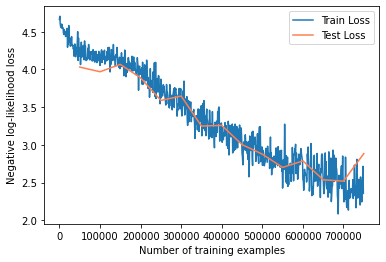

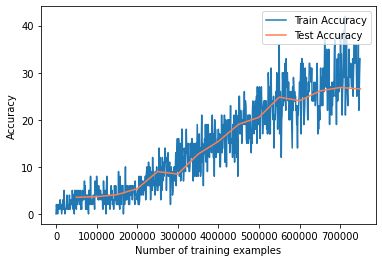

Train Epoch: 16/20 [0/50000 (0%)] Loss: 2.3286 Accuracy: 30.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 2.2271 Accuracy: 36.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 2.5617 Accuracy: 26.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 2.5270 Accuracy: 18.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 2.6352 Accuracy: 29.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 2.3644 Accuracy: 28.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 2.1563 Accuracy: 34.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 2.5371 Accuracy: 28.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 2.4922 Accuracy: 29.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 2.2331 Accuracy: 35.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 2.3763 Accuracy: 26.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 2.2449 Accuracy: 33.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 2.2314 Accuracy: 32.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 2.0577 Accuracy: 41.0000
Train Epoch: 16/20 [14000/50000 (28%)]

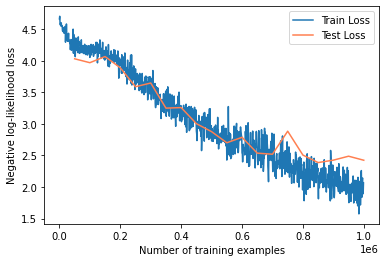

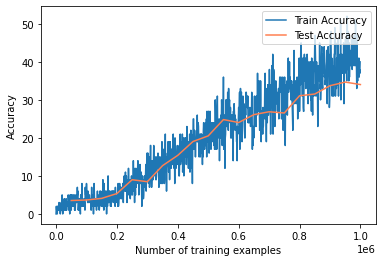

Total Time Takes 510.56343841552734.


In [ ]:
VGG19= VGG(config="VGG19").cuda()
fit(
   model=VGG19,
   name="VGG11_MNIST_NEW",
   train_loader=train_cifar100,
   test_loader=test_cifar100,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

#ResNet18_CIFAR100


Train Epoch: 1/20 [0/50000 (0%)] Loss: 4.7998 Accuracy: 2.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 4.4369 Accuracy: 6.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 4.4942 Accuracy: 3.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 4.1551 Accuracy: 9.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 4.1789 Accuracy: 4.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 3.9170 Accuracy: 14.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 3.9692 Accuracy: 7.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 3.6821 Accuracy: 11.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 3.8274 Accuracy: 14.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 3.9455 Accuracy: 9.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 3.7882 Accuracy: 8.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 3.7964 Accuracy: 9.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 3.6174 Accuracy: 17.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 3.6760 Accuracy: 15.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 3.4397 Accuracy: 

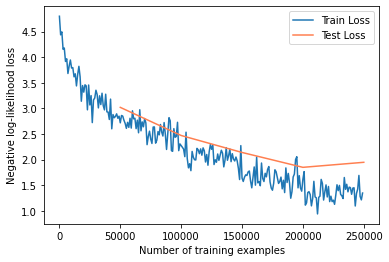

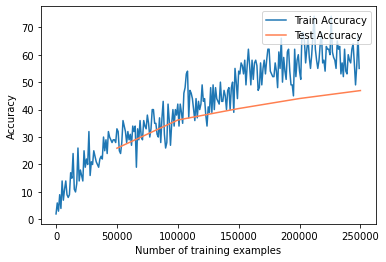

Train Epoch: 6/20 [0/50000 (0%)] Loss: 0.9046 Accuracy: 74.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 0.9877 Accuracy: 74.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 0.8574 Accuracy: 76.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 0.8952 Accuracy: 71.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 0.9606 Accuracy: 70.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 0.9344 Accuracy: 72.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 0.7489 Accuracy: 71.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 0.7689 Accuracy: 74.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 0.7837 Accuracy: 80.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 0.8288 Accuracy: 73.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 0.9842 Accuracy: 70.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 0.9431 Accuracy: 74.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 0.9742 Accuracy: 73.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 1.1262 Accuracy: 68.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 0.8719 A

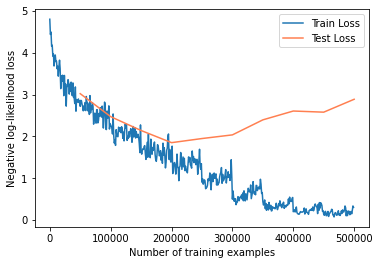

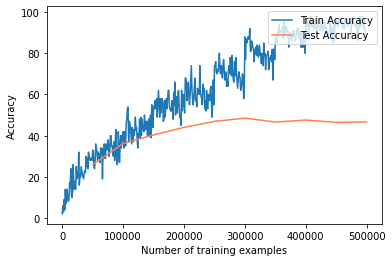

Train Epoch: 11/20 [0/50000 (0%)] Loss: 0.1561 Accuracy: 95.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 0.0888 Accuracy: 97.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 0.2318 Accuracy: 90.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 0.0988 Accuracy: 97.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 0.0871 Accuracy: 98.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 0.1035 Accuracy: 95.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 0.1228 Accuracy: 98.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 0.1401 Accuracy: 95.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 0.1889 Accuracy: 93.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 0.1114 Accuracy: 96.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 0.1253 Accuracy: 95.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 0.1408 Accuracy: 95.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 0.1585 Accuracy: 94.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 0.1077 Accuracy: 95.0000
Train Epoch: 11/20 [14000/50000 (28%)]

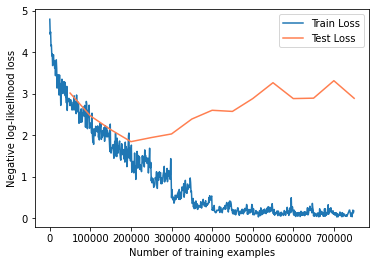

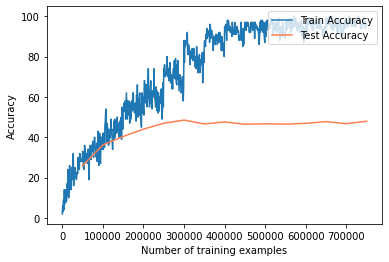

Train Epoch: 16/20 [0/50000 (0%)] Loss: 0.0595 Accuracy: 99.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 0.1600 Accuracy: 96.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 0.0871 Accuracy: 97.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 0.0392 Accuracy: 99.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 0.0992 Accuracy: 96.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 0.0713 Accuracy: 98.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 0.0969 Accuracy: 96.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 0.0992 Accuracy: 95.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 0.1711 Accuracy: 97.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 0.0669 Accuracy: 97.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 0.0323 Accuracy: 100.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 0.0501 Accuracy: 100.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 0.0741 Accuracy: 97.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 0.0830 Accuracy: 99.0000
Train Epoch: 16/20 [14000/50000 (28%

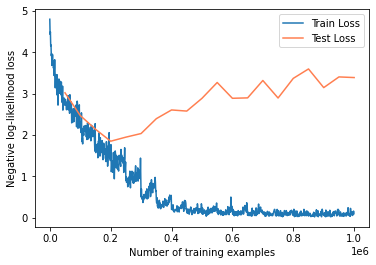

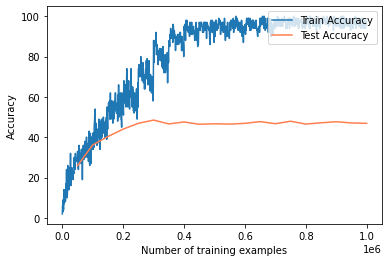

Total Time Takes 350.9189021587372.


In [ ]:
ResNet18 = ResNet(in_channels=3, num_classes=100, config="resnet18").cuda()
fit(
   model=ResNet18,
   name="ResNet34_CIFAR100",
   train_loader=train_cifar100,
   test_loader=test_cifar100,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

#ResNet34_CIFAR100


Train Epoch: 1/20 [0/50000 (0%)] Loss: 4.8395 Accuracy: 2.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 4.7782 Accuracy: 3.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 4.5807 Accuracy: 3.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 4.4876 Accuracy: 4.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 4.4451 Accuracy: 4.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 4.2526 Accuracy: 5.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 4.1535 Accuracy: 4.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 4.1464 Accuracy: 2.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 4.0015 Accuracy: 5.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 4.1846 Accuracy: 8.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 3.8642 Accuracy: 11.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 3.9545 Accuracy: 7.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 3.9145 Accuracy: 11.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 3.8891 Accuracy: 7.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 3.9176 Accuracy: 8.0

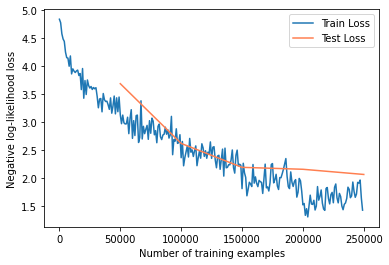

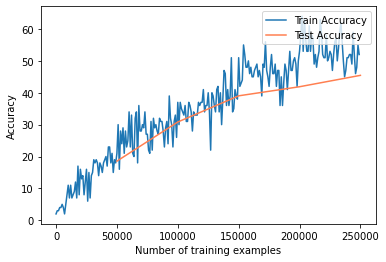

Train Epoch: 6/20 [0/50000 (0%)] Loss: 1.3192 Accuracy: 60.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 1.1530 Accuracy: 68.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 1.0646 Accuracy: 73.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 1.3582 Accuracy: 58.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 1.0595 Accuracy: 66.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 1.1938 Accuracy: 67.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 1.3032 Accuracy: 62.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 1.2226 Accuracy: 63.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 0.9395 Accuracy: 76.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 1.0606 Accuracy: 70.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 1.1371 Accuracy: 63.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 1.5238 Accuracy: 58.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 1.1085 Accuracy: 66.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 1.5419 Accuracy: 60.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 1.2261 A

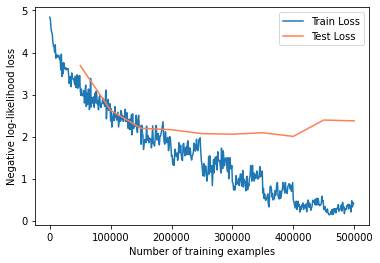

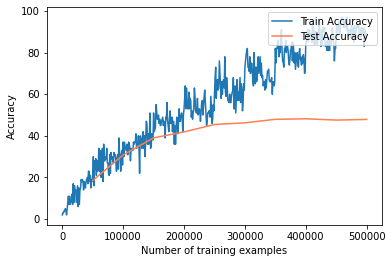

Train Epoch: 11/20 [0/50000 (0%)] Loss: 0.3063 Accuracy: 89.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 0.1752 Accuracy: 95.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 0.1912 Accuracy: 92.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 0.1972 Accuracy: 94.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 0.1976 Accuracy: 94.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 0.1681 Accuracy: 95.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 0.0959 Accuracy: 97.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 0.1335 Accuracy: 97.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 0.1147 Accuracy: 96.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 0.2174 Accuracy: 92.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 0.2107 Accuracy: 91.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 0.1727 Accuracy: 93.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 0.1504 Accuracy: 96.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 0.1930 Accuracy: 94.0000
Train Epoch: 11/20 [14000/50000 (28%)]

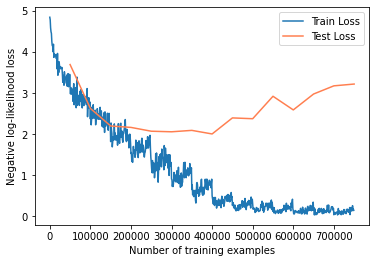

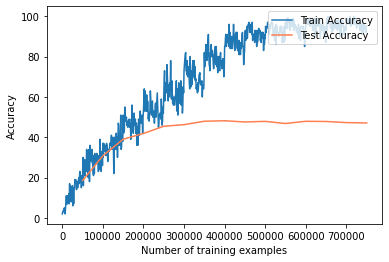

Train Epoch: 16/20 [0/50000 (0%)] Loss: 0.0685 Accuracy: 99.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 0.1642 Accuracy: 97.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 0.0763 Accuracy: 96.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 0.1213 Accuracy: 98.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 0.0386 Accuracy: 100.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 0.0267 Accuracy: 100.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 0.0987 Accuracy: 98.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 0.1089 Accuracy: 96.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 0.1095 Accuracy: 96.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 0.0626 Accuracy: 98.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 0.0489 Accuracy: 98.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 0.0735 Accuracy: 98.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 0.0793 Accuracy: 97.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 0.0673 Accuracy: 97.0000
Train Epoch: 16/20 [14000/50000 (28%

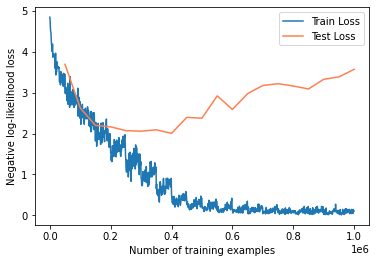

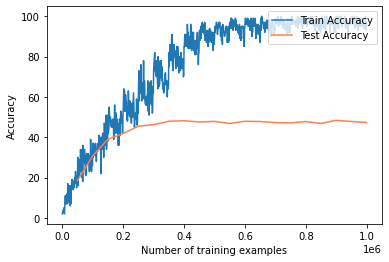

Total Time Takes 545.0182704925537.


In [ ]:
ResNet34 = ResNet(in_channels=3, num_classes=100, config="resnet34").cuda()
fit(
   model=ResNet34,
   name="ResNet34_CIFAR100",
   train_loader=train_cifar100,
   test_loader=test_cifar100,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)


# ResNet50_CIFAR100


Train Epoch: 1/20 [0/50000 (0%)] Loss: 4.8244 Accuracy: 0.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 5.6392 Accuracy: 1.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 4.5695 Accuracy: 1.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 4.5291 Accuracy: 2.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 4.6938 Accuracy: 5.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 4.7240 Accuracy: 3.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 4.7721 Accuracy: 3.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 4.6735 Accuracy: 9.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 4.0980 Accuracy: 4.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 4.3160 Accuracy: 5.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 4.2184 Accuracy: 4.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 4.6988 Accuracy: 6.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 4.0940 Accuracy: 7.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 4.2411 Accuracy: 7.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 4.5694 Accuracy: 3.000

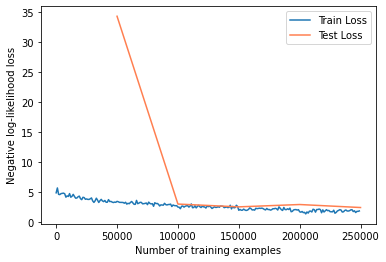

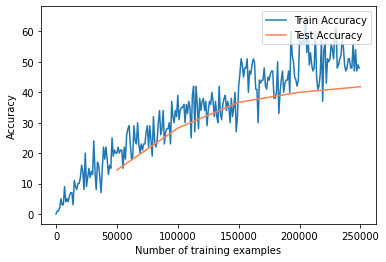

Train Epoch: 6/20 [0/50000 (0%)] Loss: 1.3632 Accuracy: 62.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 1.0770 Accuracy: 66.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 1.3909 Accuracy: 61.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 1.0441 Accuracy: 70.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 1.4162 Accuracy: 59.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 1.4260 Accuracy: 61.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 1.5741 Accuracy: 51.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 1.4025 Accuracy: 60.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 1.7485 Accuracy: 53.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 1.2691 Accuracy: 64.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 1.2567 Accuracy: 70.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 1.4063 Accuracy: 61.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 1.3237 Accuracy: 60.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 1.2957 Accuracy: 60.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 1.5764 A

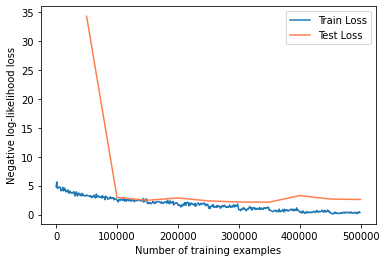

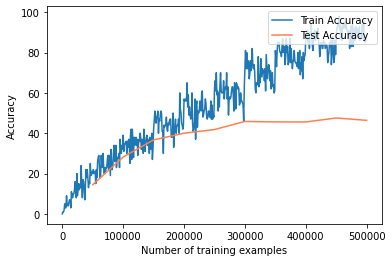

Train Epoch: 11/20 [0/50000 (0%)] Loss: 0.2590 Accuracy: 91.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 0.3134 Accuracy: 89.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 0.3382 Accuracy: 89.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 0.2313 Accuracy: 91.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 0.1663 Accuracy: 94.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 0.1337 Accuracy: 98.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 0.2117 Accuracy: 93.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 0.2535 Accuracy: 91.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 0.2087 Accuracy: 94.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 0.2827 Accuracy: 91.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 0.1597 Accuracy: 95.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 0.3032 Accuracy: 91.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 0.2967 Accuracy: 91.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 0.2871 Accuracy: 91.0000
Train Epoch: 11/20 [14000/50000 (28%)]

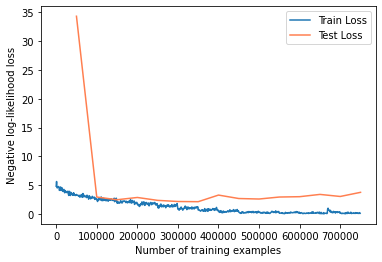

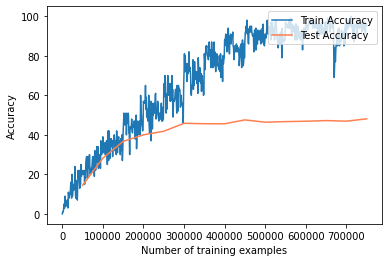

Train Epoch: 16/20 [0/50000 (0%)] Loss: 0.0364 Accuracy: 99.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 0.0209 Accuracy: 100.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 0.1344 Accuracy: 95.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 0.0303 Accuracy: 100.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 0.2216 Accuracy: 93.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 0.0883 Accuracy: 95.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 0.1088 Accuracy: 97.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 0.0340 Accuracy: 99.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 0.1439 Accuracy: 95.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 0.0634 Accuracy: 97.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 0.0564 Accuracy: 97.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 0.0603 Accuracy: 99.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 0.0302 Accuracy: 100.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 0.0919 Accuracy: 98.0000
Train Epoch: 16/20 [14000/50000 (28

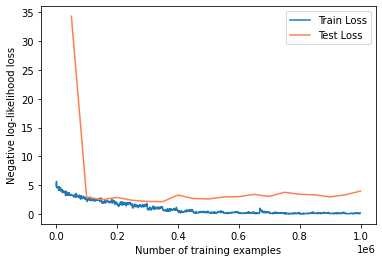

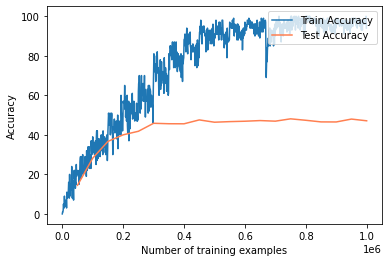

Total Time Takes 847.0144581794739.


In [ ]:
ResNet50 = ResNet(in_channels=3, num_classes=100, config="resnet50").cuda()
fit(
   model=ResNet50,
   name="ResNet34_CIFAR100",
   train_loader=train_cifar100,
   test_loader=test_cifar100,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

# Non-CNN

In [ ]:
input_size = 3072
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(
                      nn.Flatten(),
                      nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)   

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
  (6): LogSoftmax(dim=1)
)


Train Epoch: 1/5 [0/60000 (0%)] Loss: 2.3042 Accuracy: 4.0000
Train Epoch: 1/5 [1000/60000 (2%)] Loss: 1.9978 Accuracy: 37.0000
Train Epoch: 1/5 [2000/60000 (3%)] Loss: 1.4754 Accuracy: 64.0000
Train Epoch: 1/5 [3000/60000 (5%)] Loss: 0.9876 Accuracy: 70.0000
Train Epoch: 1/5 [4000/60000 (7%)] Loss: 0.6900 Accuracy: 77.0000
Train Epoch: 1/5 [5000/60000 (8%)] Loss: 0.6547 Accuracy: 81.0000
Train Epoch: 1/5 [6000/60000 (10%)] Loss: 0.4742 Accuracy: 85.0000
Train Epoch: 1/5 [7000/60000 (12%)] Loss: 0.5612 Accuracy: 85.0000
Train Epoch: 1/5 [8000/60000 (13%)] Loss: 0.4687 Accuracy: 88.0000
Train Epoch: 1/5 [9000/60000 (15%)] Loss: 0.5622 Accuracy: 83.0000
Train Epoch: 1/5 [10000/60000 (17%)] Loss: 0.3535 Accuracy: 89.0000
Train Epoch: 1/5 [11000/60000 (18%)] Loss: 0.4534 Accuracy: 86.0000
Train Epoch: 1/5 [12000/60000 (20%)] Loss: 0.3553 Accuracy: 91.0000
Train Epoch: 1/5 [13000/60000 (22%)] Loss: 0.2778 Accuracy: 94.0000
Train Epoch: 1/5 [14000/60000 (23%)] Loss: 0.4840 Accuracy: 89.0000


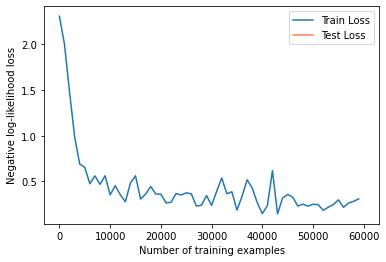

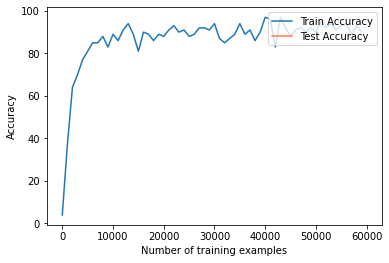

Train Epoch: 2/5 [0/60000 (0%)] Loss: 0.2353 Accuracy: 93.0000
Train Epoch: 2/5 [1000/60000 (2%)] Loss: 0.2728 Accuracy: 93.0000
Train Epoch: 2/5 [2000/60000 (3%)] Loss: 0.1667 Accuracy: 96.0000
Train Epoch: 2/5 [3000/60000 (5%)] Loss: 0.2684 Accuracy: 91.0000
Train Epoch: 2/5 [4000/60000 (7%)] Loss: 0.2157 Accuracy: 93.0000
Train Epoch: 2/5 [5000/60000 (8%)] Loss: 0.1540 Accuracy: 96.0000
Train Epoch: 2/5 [6000/60000 (10%)] Loss: 0.2230 Accuracy: 94.0000
Train Epoch: 2/5 [7000/60000 (12%)] Loss: 0.3617 Accuracy: 90.0000
Train Epoch: 2/5 [8000/60000 (13%)] Loss: 0.3252 Accuracy: 90.0000
Train Epoch: 2/5 [9000/60000 (15%)] Loss: 0.1103 Accuracy: 97.0000
Train Epoch: 2/5 [10000/60000 (17%)] Loss: 0.1964 Accuracy: 94.0000
Train Epoch: 2/5 [11000/60000 (18%)] Loss: 0.2066 Accuracy: 93.0000
Train Epoch: 2/5 [12000/60000 (20%)] Loss: 0.2618 Accuracy: 91.0000
Train Epoch: 2/5 [13000/60000 (22%)] Loss: 0.1999 Accuracy: 94.0000
Train Epoch: 2/5 [14000/60000 (23%)] Loss: 0.2202 Accuracy: 96.0000

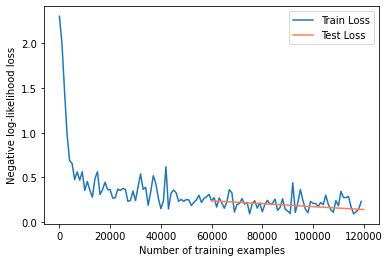

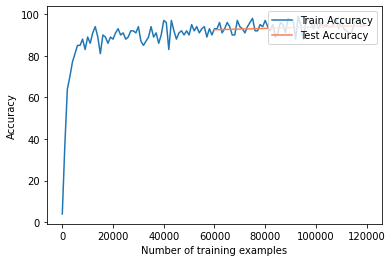

Train Epoch: 3/5 [0/60000 (0%)] Loss: 0.1790 Accuracy: 94.0000
Train Epoch: 3/5 [1000/60000 (2%)] Loss: 0.1582 Accuracy: 95.0000
Train Epoch: 3/5 [2000/60000 (3%)] Loss: 0.0637 Accuracy: 100.0000
Train Epoch: 3/5 [3000/60000 (5%)] Loss: 0.1074 Accuracy: 96.0000
Train Epoch: 3/5 [4000/60000 (7%)] Loss: 0.1153 Accuracy: 97.0000
Train Epoch: 3/5 [5000/60000 (8%)] Loss: 0.1250 Accuracy: 95.0000
Train Epoch: 3/5 [6000/60000 (10%)] Loss: 0.1813 Accuracy: 94.0000
Train Epoch: 3/5 [7000/60000 (12%)] Loss: 0.2179 Accuracy: 94.0000
Train Epoch: 3/5 [8000/60000 (13%)] Loss: 0.0767 Accuracy: 97.0000
Train Epoch: 3/5 [9000/60000 (15%)] Loss: 0.0988 Accuracy: 97.0000
Train Epoch: 3/5 [10000/60000 (17%)] Loss: 0.1327 Accuracy: 94.0000
Train Epoch: 3/5 [11000/60000 (18%)] Loss: 0.0965 Accuracy: 97.0000
Train Epoch: 3/5 [12000/60000 (20%)] Loss: 0.1061 Accuracy: 97.0000
Train Epoch: 3/5 [13000/60000 (22%)] Loss: 0.1534 Accuracy: 95.0000
Train Epoch: 3/5 [14000/60000 (23%)] Loss: 0.1600 Accuracy: 95.000

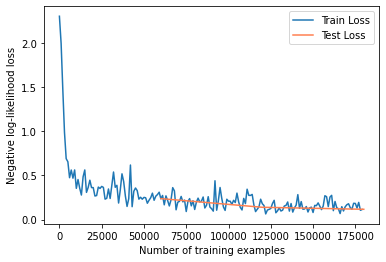

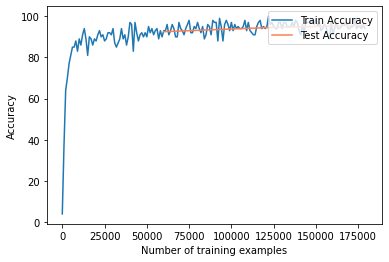

Train Epoch: 4/5 [0/60000 (0%)] Loss: 0.1185 Accuracy: 97.0000
Train Epoch: 4/5 [1000/60000 (2%)] Loss: 0.1675 Accuracy: 93.0000
Train Epoch: 4/5 [2000/60000 (3%)] Loss: 0.0866 Accuracy: 98.0000
Train Epoch: 4/5 [3000/60000 (5%)] Loss: 0.3269 Accuracy: 90.0000
Train Epoch: 4/5 [4000/60000 (7%)] Loss: 0.1796 Accuracy: 96.0000
Train Epoch: 4/5 [5000/60000 (8%)] Loss: 0.1123 Accuracy: 97.0000
Train Epoch: 4/5 [6000/60000 (10%)] Loss: 0.2525 Accuracy: 91.0000
Train Epoch: 4/5 [7000/60000 (12%)] Loss: 0.1053 Accuracy: 96.0000
Train Epoch: 4/5 [8000/60000 (13%)] Loss: 0.1223 Accuracy: 97.0000
Train Epoch: 4/5 [9000/60000 (15%)] Loss: 0.0938 Accuracy: 96.0000
Train Epoch: 4/5 [10000/60000 (17%)] Loss: 0.0701 Accuracy: 96.0000
Train Epoch: 4/5 [11000/60000 (18%)] Loss: 0.0983 Accuracy: 97.0000
Train Epoch: 4/5 [12000/60000 (20%)] Loss: 0.1132 Accuracy: 96.0000
Train Epoch: 4/5 [13000/60000 (22%)] Loss: 0.1113 Accuracy: 96.0000
Train Epoch: 4/5 [14000/60000 (23%)] Loss: 0.0777 Accuracy: 97.0000

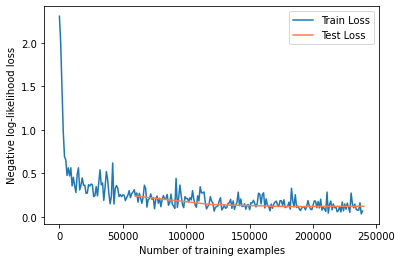

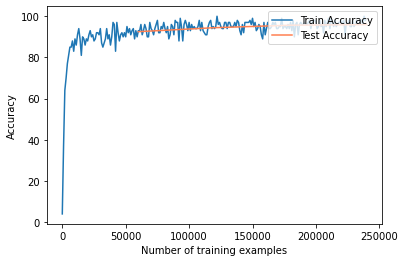

Train Epoch: 5/5 [0/60000 (0%)] Loss: 0.1182 Accuracy: 94.0000
Train Epoch: 5/5 [1000/60000 (2%)] Loss: 0.1334 Accuracy: 96.0000
Train Epoch: 5/5 [2000/60000 (3%)] Loss: 0.0778 Accuracy: 98.0000
Train Epoch: 5/5 [3000/60000 (5%)] Loss: 0.0762 Accuracy: 99.0000
Train Epoch: 5/5 [4000/60000 (7%)] Loss: 0.1017 Accuracy: 97.0000
Train Epoch: 5/5 [5000/60000 (8%)] Loss: 0.1286 Accuracy: 97.0000
Train Epoch: 5/5 [6000/60000 (10%)] Loss: 0.0709 Accuracy: 98.0000
Train Epoch: 5/5 [7000/60000 (12%)] Loss: 0.0743 Accuracy: 98.0000
Train Epoch: 5/5 [8000/60000 (13%)] Loss: 0.1127 Accuracy: 97.0000
Train Epoch: 5/5 [9000/60000 (15%)] Loss: 0.1176 Accuracy: 94.0000
Train Epoch: 5/5 [10000/60000 (17%)] Loss: 0.1856 Accuracy: 94.0000
Train Epoch: 5/5 [11000/60000 (18%)] Loss: 0.1325 Accuracy: 95.0000
Train Epoch: 5/5 [12000/60000 (20%)] Loss: 0.1024 Accuracy: 95.0000
Train Epoch: 5/5 [13000/60000 (22%)] Loss: 0.0759 Accuracy: 98.0000
Train Epoch: 5/5 [14000/60000 (23%)] Loss: 0.1276 Accuracy: 97.0000

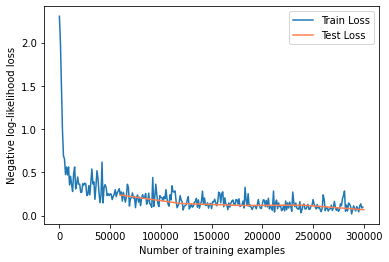

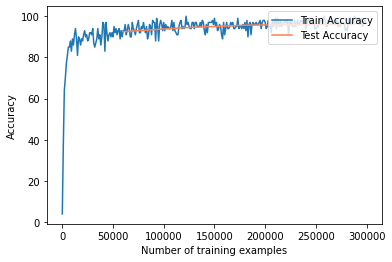

Total Time Takes 80.15261220932007.


In [ ]:
model = model.cuda()
fit(
   model=model,
   name="name",
   train_loader=train_mnist,
   test_loader=test_mnist,
   epoches=5,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=False
)

Train Epoch: 1/20 [0/50000 (0%)] Loss: 2.3075 Accuracy: 9.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 1.9356 Accuracy: 34.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 2.0402 Accuracy: 22.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 1.7683 Accuracy: 40.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 1.8781 Accuracy: 33.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 1.9236 Accuracy: 33.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 1.7468 Accuracy: 34.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 1.7930 Accuracy: 39.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 1.7329 Accuracy: 41.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 1.6975 Accuracy: 40.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 1.5543 Accuracy: 43.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 2.0056 Accuracy: 34.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 1.6024 Accuracy: 41.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 1.7541 Accuracy: 38.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 1.4923 Ac

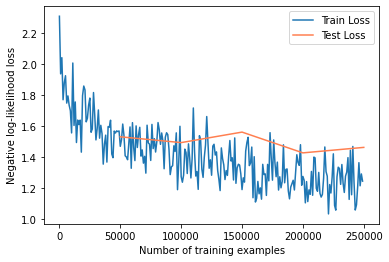

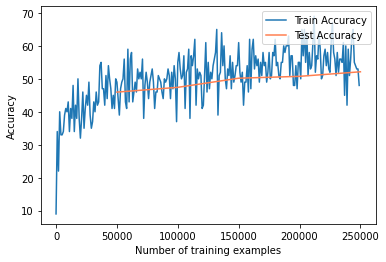

Train Epoch: 6/20 [0/50000 (0%)] Loss: 1.1489 Accuracy: 62.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 1.0726 Accuracy: 64.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 1.1357 Accuracy: 60.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 1.2540 Accuracy: 51.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 1.1920 Accuracy: 57.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 1.1760 Accuracy: 54.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 1.1214 Accuracy: 63.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 1.2366 Accuracy: 59.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 1.2261 Accuracy: 55.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 1.1333 Accuracy: 58.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 1.1379 Accuracy: 62.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 1.0990 Accuracy: 62.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 1.1717 Accuracy: 54.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 1.2340 Accuracy: 56.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 1.3375 A

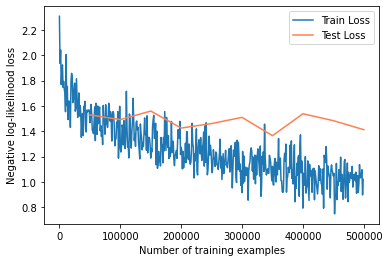

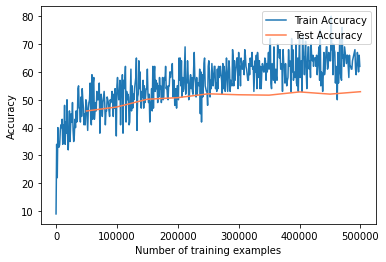

Train Epoch: 11/20 [0/50000 (0%)] Loss: 0.8258 Accuracy: 71.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 0.9495 Accuracy: 65.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 0.9727 Accuracy: 65.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 0.8887 Accuracy: 68.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 1.0010 Accuracy: 59.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 0.8259 Accuracy: 73.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 1.0507 Accuracy: 61.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 1.0933 Accuracy: 66.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 1.0867 Accuracy: 63.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 0.9711 Accuracy: 60.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 1.0728 Accuracy: 60.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 0.9183 Accuracy: 67.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 1.1835 Accuracy: 54.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 0.9729 Accuracy: 67.0000
Train Epoch: 11/20 [14000/50000 (28%)]

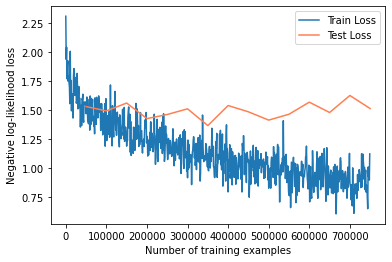

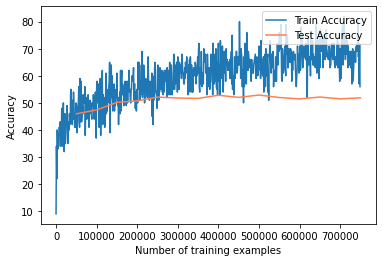

Train Epoch: 16/20 [0/50000 (0%)] Loss: 0.9779 Accuracy: 64.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 0.8584 Accuracy: 75.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 0.8950 Accuracy: 73.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 0.6398 Accuracy: 70.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 0.9098 Accuracy: 68.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 0.8613 Accuracy: 66.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 0.7971 Accuracy: 72.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 0.8623 Accuracy: 61.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 0.7269 Accuracy: 72.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 0.9353 Accuracy: 76.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 0.9954 Accuracy: 65.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 0.8272 Accuracy: 75.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 0.9223 Accuracy: 68.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 0.7916 Accuracy: 74.0000
Train Epoch: 16/20 [14000/50000 (28%)]

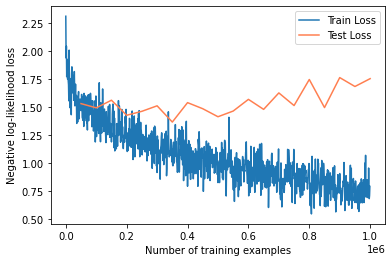

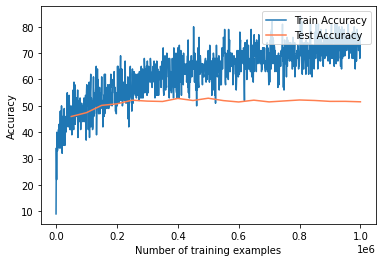

Total Time Takes 200.5392200946808.


In [ ]:
model = model.cuda()
fit(
   model=model,
   name="name",
   train_loader=train_cifar10,
   test_loader=test_cifar10,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)

Train Epoch: 1/20 [0/50000 (0%)] Loss: 3.3054 Accuracy: 21.0000
Train Epoch: 1/20 [1000/50000 (2%)] Loss: 3.4359 Accuracy: 18.0000
Train Epoch: 1/20 [2000/50000 (4%)] Loss: 3.6849 Accuracy: 14.0000
Train Epoch: 1/20 [3000/50000 (6%)] Loss: 3.6593 Accuracy: 16.0000
Train Epoch: 1/20 [4000/50000 (8%)] Loss: 3.5771 Accuracy: 20.0000
Train Epoch: 1/20 [5000/50000 (10%)] Loss: 3.4615 Accuracy: 14.0000
Train Epoch: 1/20 [6000/50000 (12%)] Loss: 3.3116 Accuracy: 9.0000
Train Epoch: 1/20 [7000/50000 (14%)] Loss: 3.6597 Accuracy: 13.0000
Train Epoch: 1/20 [8000/50000 (16%)] Loss: 3.6077 Accuracy: 16.0000
Train Epoch: 1/20 [9000/50000 (18%)] Loss: 3.3941 Accuracy: 18.0000
Train Epoch: 1/20 [10000/50000 (20%)] Loss: 3.4684 Accuracy: 17.0000
Train Epoch: 1/20 [11000/50000 (22%)] Loss: 3.3515 Accuracy: 33.0000
Train Epoch: 1/20 [12000/50000 (24%)] Loss: 3.1980 Accuracy: 22.0000
Train Epoch: 1/20 [13000/50000 (26%)] Loss: 3.2648 Accuracy: 22.0000
Train Epoch: 1/20 [14000/50000 (28%)] Loss: 3.4348 Ac

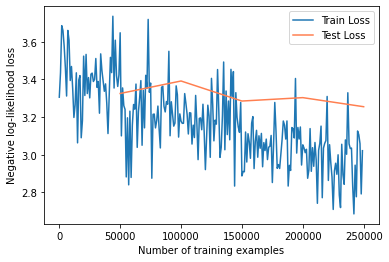

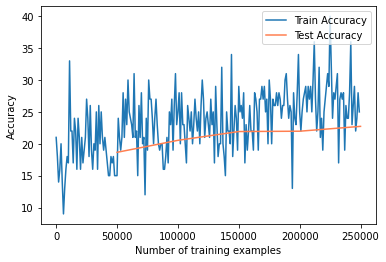

Train Epoch: 6/20 [0/50000 (0%)] Loss: 2.9532 Accuracy: 22.0000
Train Epoch: 6/20 [1000/50000 (2%)] Loss: 2.7045 Accuracy: 34.0000
Train Epoch: 6/20 [2000/50000 (4%)] Loss: 2.8675 Accuracy: 28.0000
Train Epoch: 6/20 [3000/50000 (6%)] Loss: 2.8336 Accuracy: 31.0000
Train Epoch: 6/20 [4000/50000 (8%)] Loss: 3.0590 Accuracy: 23.0000
Train Epoch: 6/20 [5000/50000 (10%)] Loss: 3.0083 Accuracy: 24.0000
Train Epoch: 6/20 [6000/50000 (12%)] Loss: 3.1371 Accuracy: 18.0000
Train Epoch: 6/20 [7000/50000 (14%)] Loss: 2.8693 Accuracy: 27.0000
Train Epoch: 6/20 [8000/50000 (16%)] Loss: 2.5747 Accuracy: 31.0000
Train Epoch: 6/20 [9000/50000 (18%)] Loss: 2.8588 Accuracy: 32.0000
Train Epoch: 6/20 [10000/50000 (20%)] Loss: 2.8752 Accuracy: 28.0000
Train Epoch: 6/20 [11000/50000 (22%)] Loss: 3.0483 Accuracy: 19.0000
Train Epoch: 6/20 [12000/50000 (24%)] Loss: 2.8984 Accuracy: 35.0000
Train Epoch: 6/20 [13000/50000 (26%)] Loss: 2.9911 Accuracy: 28.0000
Train Epoch: 6/20 [14000/50000 (28%)] Loss: 3.0008 A

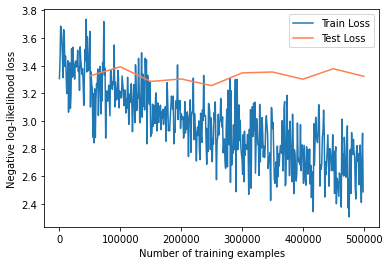

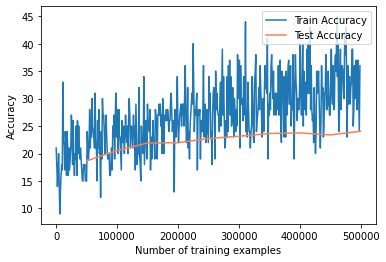

Train Epoch: 11/20 [0/50000 (0%)] Loss: 2.4600 Accuracy: 34.0000
Train Epoch: 11/20 [1000/50000 (2%)] Loss: 2.4525 Accuracy: 32.0000
Train Epoch: 11/20 [2000/50000 (4%)] Loss: 2.7405 Accuracy: 32.0000
Train Epoch: 11/20 [3000/50000 (6%)] Loss: 2.6836 Accuracy: 38.0000
Train Epoch: 11/20 [4000/50000 (8%)] Loss: 2.5363 Accuracy: 26.0000
Train Epoch: 11/20 [5000/50000 (10%)] Loss: 2.6570 Accuracy: 27.0000
Train Epoch: 11/20 [6000/50000 (12%)] Loss: 2.4085 Accuracy: 44.0000
Train Epoch: 11/20 [7000/50000 (14%)] Loss: 2.5020 Accuracy: 36.0000
Train Epoch: 11/20 [8000/50000 (16%)] Loss: 2.8498 Accuracy: 26.0000
Train Epoch: 11/20 [9000/50000 (18%)] Loss: 2.6172 Accuracy: 30.0000
Train Epoch: 11/20 [10000/50000 (20%)] Loss: 2.5227 Accuracy: 32.0000
Train Epoch: 11/20 [11000/50000 (22%)] Loss: 2.3706 Accuracy: 43.0000
Train Epoch: 11/20 [12000/50000 (24%)] Loss: 2.8986 Accuracy: 30.0000
Train Epoch: 11/20 [13000/50000 (26%)] Loss: 2.4494 Accuracy: 34.0000
Train Epoch: 11/20 [14000/50000 (28%)]

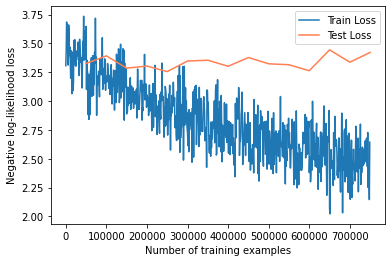

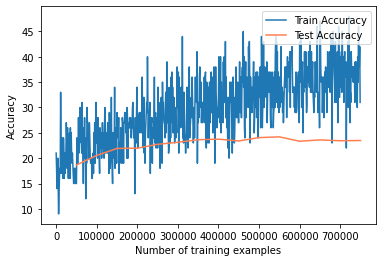

Train Epoch: 16/20 [0/50000 (0%)] Loss: 2.1096 Accuracy: 51.0000
Train Epoch: 16/20 [1000/50000 (2%)] Loss: 2.5872 Accuracy: 30.0000
Train Epoch: 16/20 [2000/50000 (4%)] Loss: 2.3695 Accuracy: 41.0000
Train Epoch: 16/20 [3000/50000 (6%)] Loss: 2.4673 Accuracy: 35.0000
Train Epoch: 16/20 [4000/50000 (8%)] Loss: 2.2130 Accuracy: 37.0000
Train Epoch: 16/20 [5000/50000 (10%)] Loss: 2.1318 Accuracy: 45.0000
Train Epoch: 16/20 [6000/50000 (12%)] Loss: 2.1903 Accuracy: 42.0000
Train Epoch: 16/20 [7000/50000 (14%)] Loss: 2.2337 Accuracy: 40.0000
Train Epoch: 16/20 [8000/50000 (16%)] Loss: 2.5311 Accuracy: 33.0000
Train Epoch: 16/20 [9000/50000 (18%)] Loss: 2.3929 Accuracy: 39.0000
Train Epoch: 16/20 [10000/50000 (20%)] Loss: 2.6401 Accuracy: 37.0000
Train Epoch: 16/20 [11000/50000 (22%)] Loss: 2.2014 Accuracy: 46.0000
Train Epoch: 16/20 [12000/50000 (24%)] Loss: 2.6908 Accuracy: 35.0000
Train Epoch: 16/20 [13000/50000 (26%)] Loss: 2.3564 Accuracy: 42.0000
Train Epoch: 16/20 [14000/50000 (28%)]

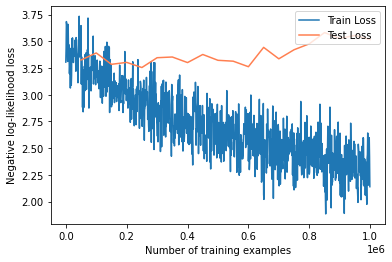

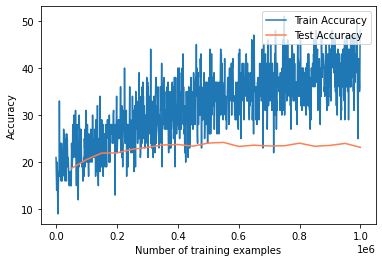

Total Time Takes 199.25136756896973.


In [ ]:
model = model.cuda()
fit(
   model=model,
   name="name",
   train_loader=train_cifar100,
   test_loader=test_cifar100,
   epoches=20,
   learning_rate=0.001,
   log_interval=10,
   loss_function=CrossEntropyLoss(),
   deep_mode=True
)